# Givens Estates 5-yr Monitoring Data Processing
This notebook was made to take in wrangled sediment and water stage timestamp data, then calculate all discharges, sediment loads, and create the necessary output csv's and plots. - SK

In [1]:
# Loads
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment wh ile working

# Reset all rcParams to default values
mpl.rcParams.update(mpl.rcParamsDefault)

# change font to RDE font
# Stolzl Book
plt.rcParams['font.family'] = 'Stolzl'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Stolzl'  # Roman (non-italic) text in math mode
plt.rcParams['mathtext.it'] = 'Stolzl:italic'  # Italic text in math mode
plt.rcParams['mathtext.bf'] = 'Stolzl:bold'  # Bold text in math mode
# Stolzl Medium
# idk
# Knile
# plt.rcParams['font.family'] = 'Knile'
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'Knile'  # Roman (non-italic) text in math mode
# plt.rcParams['mathtext.it'] = 'Knile'  # Italic text in math mode
# plt.rcParams['mathtext.bf'] = 'Knile'  # Bold text in math mode
# fig1, ax1 = plt.subplots()

In [2]:
# Load in wrangled data
stage_df = pd.read_excel('Givens_5-yr_DataCombine_SK.xlsx', sheet_name='stage_combine')
stage_df.rename(columns={'date-time': 'date_time_stage'}, inplace=True)
sed_df = pd.read_excel('Givens_5-yr_DataCombine_SK.xlsx', sheet_name='ISCO_combine')

# make sure date_timestamp columns are right data type
stage_df['date_time_stage'] = stage_df['date_time_stage'].values.astype('datetime64[ns]')
sed_df['date_time_ISCO'] = sed_df['Date-Time_ISCO'].values.astype('datetime64[ns]')

# drop any rows where no ISCO timestamp, no sed lab msmts, or no stage or stage timestamp; remove duplicate timestamps (overlap in data)
stage_df = stage_df.dropna(subset=['date_time_stage','stage_corrected_ft'])
sed_df = sed_df.dropna(subset=['date_time_ISCO','Vol_Tot_mL', 'Sed_Wt_g'])
stage_df = stage_df.drop_duplicates(subset='date_time_stage')
sed_df = sed_df.drop_duplicates(subset='date_time_ISCO')

display(stage_df)
display(sed_df)

,date_time_stage,stage_raw,stage_corrected_ft
0,2018-04-15 08:23:00,4.0000,0.333333
1,2018-04-15 09:51:00,10.0000,0.833333
2,2018-04-15 10:11:00,19.5000,1.625000
3,2018-04-15 10:20:00,15.5000,1.291667
4,2018-04-15 10:30:00,13.0000,1.083333
...,...,...,...
184772,2024-08-20 08:51:13,0.1164,0.116400
184773,2024-08-20 08:56:13,0.1129,0.112900
184774,2024-08-20 09:01:13,0.1090,0.109000
184775,2024-08-20 09:06:13,0.1152,0.115200


,Date-Time_ISCO,Bottle_No_ISCO,Lab_Submission_Date,Bottle_No_SedLab,Vol_Tot_mL,Sed_Wt_g,Sed_Conc_mg_L,Load_g_s,Notes,Highlight_Excel_ISCO,Red_Excel_ISCO,date_time_ISCO
0,2018-04-15 08:23:00,NaN,2018-04-25,Blue Bottle,380.0,0.1351,355.526316,NaN,"couldn't find original ISCO bottle timestamps,...",0,0,2018-04-15 08:23:00
1,2018-04-15 09:51:00,NaN,2018-04-25,3,453.0,0.7152,1578.807947,NaN,"couldn't find original ISCO bottle timestamps,...",0,0,2018-04-15 09:51:00
2,2018-04-15 10:11:00,NaN,2018-04-25,4,456.0,1.6123,3535.745614,NaN,"couldn't find original ISCO bottle timestamps,...",0,0,2018-04-15 10:11:00
3,2018-04-15 10:20:00,NaN,2018-04-25,5,456.0,3.8201,8377.412281,NaN,"couldn't find original ISCO bottle timestamps,...",0,0,2018-04-15 10:20:00
4,2018-04-15 10:30:00,NaN,2018-04-25,6,460.0,1.5410,3350.000000,NaN,"couldn't find original ISCO bottle timestamps,...",0,0,2018-04-15 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
428,2024-05-23 23:37:00,NaN,2024-05-25,37,399.0,0.3061,767.167920,NaN,"SedLab data paired to 24417.Sediment Calcs, no...",0,0,2024-05-23 23:37:00
429,2024-07-07 14:29:00,1.0,2024-07-11,1,399.0,0.1973,494.486216,NaN,SedLab data paired to ISCO screen photos; weir...,0,0,2024-07-07 14:29:00
430,2024-07-07 14:58:00,2.0,2024-07-11,2,404.0,0.2784,689.108911,NaN,SedLab data paired to ISCO screen photos; weir...,0,0,2024-07-07 14:58:00
431,2024-07-07 16:14:00,3.0,2024-07-11,3,403.0,0.0089,22.084367,NaN,SedLab data paired to ISCO screen photos; weir...,0,0,2024-07-07 16:14:00


In [3]:
# combine dfs - match with nearest timestamp
# Function to find the closest timestamp index - from ChatGPT
def find_closest_time_index(time, df, time_col):
    return (df[time_col] - time).abs().idxmin()

# copy some dataframes to prepare for looping
dummy_stage_df = stage_df.copy()
result_df = stage_df.copy()

# initialize new columns that will be added to stage_df
result_df['date_time_isco'] = pd.NaT
result_df['conc_mg_L'] = np.nan

# Align the dataframes - from ChatGPT
for _, row in sed_df.iterrows():
    closest_index = find_closest_time_index(row['date_time_ISCO'], dummy_stage_df, 'date_time_stage')
    closest_row = dummy_stage_df.loc[closest_index]

    # Update the corresponding row in the result dataframe
    result_df.loc[result_df['date_time_stage'] == closest_row['date_time_stage'], 'date_time_isco'] = row['date_time_ISCO']
    result_df.loc[result_df['date_time_stage'] == closest_row['date_time_stage'], 'conc_mg_L'] = row['Sed_Wt_g']/row['Vol_Tot_mL']*1000**2
    
    # Remove the matched row from dummy_stage_df to avoid repeats
    dummy_stage_df = dummy_stage_df.drop(closest_index)

stage_sed_df = result_df
stage_sed_df.to_csv('stage_sediment_combine.csv', index=False)

In [4]:
# look at specific range
result_df[(stage_sed_df['date_time_isco'] > np.datetime64('2024-05-17 15:00:00')) & (stage_sed_df['date_time_isco'] < np.datetime64('2024-05-17 17:00:00'))]

,date_time_stage,stage_raw,stage_corrected_ft,date_time_isco,conc_mg_L
128225,2024-05-17 15:27:49,0.4070,0.4070,2024-05-17 15:27:00,511.442786
128226,2024-05-17 15:32:49,0.2976,0.2976,2024-05-17 15:32:00,423.134328
128228,2024-05-17 15:42:49,0.3735,0.3735,2024-05-17 15:42:00,458.955224
128230,2024-05-17 15:52:49,0.3248,0.3248,2024-05-17 15:52:00,16.169154
128232,2024-05-17 16:02:49,0.3819,0.3819,2024-05-17 16:02:00,273.880597
128234,2024-05-17 16:12:49,0.4020,0.4020,2024-05-17 16:12:00,22.194514
128236,2024-05-17 16:22:49,0.3692,0.3692,2024-05-17 16:22:00,10.723192
128238,2024-05-17 16:32:49,0.3532,0.3532,2024-05-17 16:32:00,12.219451
128240,2024-05-17 16:42:49,0.3525,0.3525,2024-05-17 16:42:00,24.438903
128242,2024-05-17 16:52:49,0.3359,0.3359,2024-05-17 16:52:00,25.373134


In [5]:
# functionizing the hand-drawn curves for Ce of a partially-contracted v-notch weir

# Kulin and Compton 1975 Fig 4-5: Ce for partially-contracted v-notch weirs
# Using GeoGebra on image, making points, then PolyFit() polynomial curve fitting
# P/B = 1.0
# 380.3109110700038x^(6) - 564.6042445931643x^(5) + 334.8942428178557x^(4) - 100.3409026491789x^(3) + 15.9645346761014x^(2) - 1.2744715661067x + 0.6181601989942
# P/B = 0.8
# -2098.188266193364x^(8) + 4822.136683514677x^(7) - 4618.7836909284715x^(6) + 2388.1739432881486x^(5) - 722.6932711275226x^(4) + 130.3406886569203x^(3) - 13.6548795540878x^(2) + 0.7652761902615x + 0.5604543922725
# P/B = 0.6
# 3.5509969570713x^(6) - 7.6054084567142x^(5) + 6.1075340060361x^(4) - 2.1470998115822x^(3) + 0.3240549526796x^(2) - 0.0118348270028x + 0.5777004528603
# P/B = 0.4
# -326.2748669937048x^(11) + 1999.9815196019158x^(10) - 5376.586364087006x^(9) + 8329.485298705671x^(8) - 8219.396721238372x^(7) + 5392.87319867412x^(6) - 2385.9814006935103x^(5) + 707.7160459825956x^(4) - 137.2078078095456x^(3) + 16.4747600800621x^(2) - 1.0931938246613x + 0.608460034015
# P/B = 0.3
# -55.5246831179059x^(11) + 385.9421994215697x^(10) - 1172.777992197495x^(9) + 2045.95965628624x^(8) - 2263.169149753214x^(7) + 1655.456934299524x^(6) - 811.1922174539758x^(5) + 264.4084043205384x^(4) - 55.8169137604434x^(3) + 7.2148793901404x^(2) - 0.5061745895971x + 0.5927399876207
# P/B = 0.2
# -0.1776021827636x^(8) + 1.2367993513345x^(7) - 3.3601376637499x^(6) + 4.6649758699716x^(5) - 3.5963305902167x^(4) + 1.5750016012957x^(3) - 0.3915495246612x^(2) + 0.0537761462335x + 0.5754430976103
# P/B = 0.1
# 0.0040400722952x^(4) - 0.0022811100135x^(3) - 0.0098778444155x^(2) + 0.0074465337219x + 0.5775820332236

# limit points: order of x-min, 1.0, 0.8, 0.6, 0.4, 0.3, 0.2, 0.1
# A=(0.0989811416743,0.5782130563246) # all lines
# B=(0.3898705692441,0.5889729523452) # P/B = 1.0
# C=(0.5037674165547,0.5927945381178) # P/B = 0.8
# D=(0.6562955781038,0.5933648839001) # P/B = 0.6
# E=(0.9959266153994,0.598745504488) # P/B = 0.4
# F=(1.1639322663365,0.5928052993589) # P/B = 0.3
# G=(1.1799090295757,0.5826789714125) # P/B = 0.2
# H=(1.1840280388483,0.5765773476658) # P/B = 0.1

# when interpolating lines of P/B, extrapolate and use last (x,y) plus some sloped linear middle line
def Ce_part_vnotch(H,P,B): # H is head above crest (invert of weir), P is vertical distance crest to upstream bed, B is width of approach channel (e.g., top width of entire weir, including any horizontal crest on either side of v-notch)
    HP = H/P
    PB = np.round(P/B, 2)
    # if H/B > 0.4:
    #     print('Warning: H/B = {:.3f} > 0.4 - this weir does not meet the criteria for partial contraction.'.format(H/B))
    # print('PB = ', PB)
    if PB > 0.09 and PB < 0.11:
        # if HP < 0.1 or HP > 1.18:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.18:
            Ce = 0.58
        else:
            Ce = 0.0040400722952*HP**4 - 0.0022811100135*HP**3 - 0.0098778444155*HP**2 + 0.0074465337219*HP + 0.5775820332236
    elif PB >= 0.11 and PB <=0.19:
        # if HP < 0.1 or HP > 1.18:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.18:
            Ce = 0.58
        else: # interpolate
            Ce_PB01 = 0.0040400722952*HP**4 - 0.0022811100135*HP**3 - 0.0098778444155*HP**2 + 0.0074465337219*HP + 0.5775820332236
            Ce_PB02 = -0.1776021827636*HP**8 + 1.2367993513345*HP**7 - 3.3601376637499*HP**6 + 4.6649758699716*HP**5 - 3.5963305902167*HP**4 + 1.5750016012957*HP**3 - 0.3915495246612*HP**2 + 0.0537761462335*HP + 0.5754430976103
            Ce = (Ce_PB01+Ce_PB02)/2
    elif PB > 0.19 and PB < 0.21:
        if HP < 0.1 or HP > 1.18:
            Ce = np.nan
            # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.18:
            Ce = 0.58
        else:
            Ce = -0.1776021827636*HP**8 + 1.2367993513345*HP**7 - 3.3601376637499*HP**6 + 4.6649758699716*HP**5 - 3.5963305902167*HP**4 + 1.5750016012957*HP**3 - 0.3915495246612*HP**2 + 0.0537761462335*HP + 0.5754430976103
    elif PB >= 0.21 and PB <=0.29:
        # if HP < 0.1 or HP > 1.16:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.16:
            Ce = 0.59
        else: # interpolate
            Ce_PB02 = -0.1776021827636*HP**8 + 1.2367993513345*HP**7 - 3.3601376637499*HP**6 + 4.6649758699716*HP**5 - 3.5963305902167*HP**4 + 1.5750016012957*HP**3 - 0.3915495246612*HP**2 + 0.0537761462335*HP + 0.5754430976103
            Ce_PB03 = -55.5246831179059*HP**11 + 385.9421994215697*HP**10 - 1172.777992197495*HP**9 + 2045.95965628624*HP**8 - 2263.169149753214*HP**7 + 1655.456934299524*HP**6 - 811.1922174539758*HP**5 + 264.4084043205384*HP**4 - 55.8169137604434*HP**3 + 7.2148793901404*HP**2 - 0.5061745895971*HP + 0.5927399876207
            Ce = (Ce_PB02+Ce_PB03)/2
    elif PB > 0.29 and PB < 0.31:
        # if HP < 0.1 or HP > 1.16:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.16:
            Ce = 0.59
        else:
            Ce = -55.5246831179059*HP**11 + 385.9421994215697*HP**10 - 1172.777992197495*HP**9 + 2045.95965628624*HP**8 - 2263.169149753214*HP**7 + 1655.456934299524*HP**6 - 811.1922174539758*HP**5 + 264.4084043205384*HP**4 - 55.8169137604434*HP**3 + 7.2148793901404*HP**2 - 0.5061745895971*HP + 0.5927399876207
    elif PB >= 0.31 and PB <=0.39:
        # if HP < 0.1 or HP > 1.1:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.1:
            Ce = 0.59
        elif HP > 1.0 and HP <= 1.1: # extrapolate
            Ce = 0.5933056322910634 + 0.05*(HP-1.0) # 0.05 just estimated from plotting and checking
        else: # interpolate
            Ce_PB03 = -55.5246831179059*HP**11 + 385.9421994215697*HP**10 - 1172.777992197495*HP**9 + 2045.95965628624*HP**8 - 2263.169149753214*HP**7 + 1655.456934299524*HP**6 - 811.1922174539758*HP**5 + 264.4084043205384*HP**4 - 55.8169137604434*HP**3 + 7.2148793901404*HP**2 - 0.5061745895971*HP + 0.5927399876207
            Ce_PB04 = -326.2748669937048*HP**11 + 1999.9815196019158*HP**10 - 5376.586364087006*HP**9 + 8329.485298705671*HP**8 - 8219.396721238372*HP**7 + 5392.87319867412*HP**6 - 2385.9814006935103*HP**5 + 707.7160459825956*HP**4 - 137.2078078095456*HP**3 + 16.4747600800621*HP**2 - 1.0931938246613*HP + 0.608460034015
            Ce = (Ce_PB03+Ce_PB04)/2
    elif PB > 0.39 and PB < 0.41:
        # if HP < 0.1 or HP > 1.0:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 1.0:
            Ce = 0.60
        else:
            Ce = -326.2748669937048*HP**11 + 1999.9815196019158*HP**10 - 5376.586364087006*HP**9 + 8329.485298705671*HP**8 - 8219.396721238372*HP**7 + 5392.87319867412*HP**6 - 2385.9814006935103*HP**5 + 707.7160459825956*HP**4 - 137.2078078095456*HP**3 + 16.4747600800621*HP**2 - 1.0931938246613*HP + 0.608460034015
    elif PB >= 0.41 and PB <=0.59:
        # if HP < 0.1 or HP > 0.8:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 0.8:
            Ce = 0.59
        elif HP > 0.66 and HP <= 0.8: # extrapolate 
            Ce = 0.5883652546103659 + 0.06*(HP-0.66) # 0.06 just estimated from plotting and checking
        else: # interpolate
            Ce_PB04 = -326.2748669937048*HP**11 + 1999.9815196019158*HP**10 - 5376.586364087006*HP**9 + 8329.485298705671*HP**8 - 8219.396721238372*HP**7 + 5392.87319867412*HP**6 - 2385.9814006935103*HP**5 + 707.7160459825956*HP**4 - 137.2078078095456*HP**3 + 16.4747600800621*HP**2 - 1.0931938246613*HP + 0.608460034015
            Ce_PB06 = 3.5509969570713*HP**6 - 7.6054084567142*HP**5 + 6.1075340060361*HP**4 - 2.1470998115822*HP**3 + 0.3240549526796*HP**2 - 0.0118348270028*HP + 0.5777004528603
            Ce = (Ce_PB04+Ce_PB06)/2
    elif PB > 0.59 and PB < 0.61:
        # if HP < 0.1 or HP > 0.66:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 0.66:
            Ce = 0.59
        else:
            Ce = 3.5509969570713*HP**6 - 7.6054084567142*HP**5 + 6.1075340060361*HP**4 - 2.1470998115822*HP**3 + 0.3240549526796*HP**2 - 0.0118348270028*HP + 0.5777004528603
    elif PB >=0.61 and PB <=0.79:
        # if HP < 0.1 or HP > 0.58:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 0.58:
            Ce = 0.59
        elif HP > 0.5 and HP <= 0.58: # extrapolate 
            Ce = 0.5882051036521176 + 0.05*(HP-0.5) # 0.07 just estimated from plotting and checking
        else: # interpolate
            Ce_PB06 = 3.5509969570713*HP**6 - 7.6054084567142*HP**5 + 6.1075340060361*HP**4 - 2.1470998115822*HP**3 + 0.3240549526796*HP**2 - 0.0118348270028*HP + 0.5777004528603
            Ce_PB08 = -2098.188266193364*HP**8 + 4822.136683514677*HP**7 - 4618.7836909284715*HP**6 + 2388.1739432881486*HP**5 - 722.6932711275226*HP**4 + 130.3406886569203*HP**3 - 13.6548795540878*HP**2 + 0.7652761902615*HP + 0.5604543922725
            Ce = (Ce_PB06+Ce_PB08)/2
    elif PB > 0.79 and PB < 0.81:
        # if HP < 0.1 or HP > 0.5:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 0.5:
            Ce = 0.59
        else:
            Ce = -2098.188266193364*HP**8 + 4822.136683514677*HP**7 - 4618.7836909284715*HP**6 + 2388.1739432881486*HP**5 - 722.6932711275226*HP**4 + 130.3406886569203*HP**3 - 13.6548795540878*HP**2 + 0.7652761902615*HP + 0.5604543922725
    elif PB >=0.81 and PB <=0.99:
        # if HP < 0.1 or HP > 0.45:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 0.45:
            Ce = 0.59
        elif HP > 0.39 and HP <= 0.45: # extrapolate 
            Ce = 0.5864044129015097 + 0.1*(HP-0.39) # 0.1 just estimated from plotting and checking
        else: # interpolate
            Ce_PB08 = -2098.188266193364*HP**8 + 4822.136683514677*HP**7 - 4618.7836909284715*HP**6 + 2388.1739432881486*HP**5 - 722.6932711275226*HP**4 + 130.3406886569203*HP**3 - 13.6548795540878*HP**2 + 0.7652761902615*HP + 0.5604543922725
            Ce_PB10 = 380.3109110700038*HP**6 - 564.6042445931643*HP**5 + 334.8942428178557*HP**4 - 100.3409026491789*HP**3 + 15.9645346761014*HP**2 - 1.2744715661067*HP + 0.6181601989942
            Ce = (Ce_PB08+Ce_PB10)/2
    elif PB > 0.99 and PB < 1.1:
        # if HP < 0.1 or HP > 0.39:
        #     Ce = np.nan
        #     # print('Error: H/P value out of bounds of plotted range.')
        if HP < 0.1:
            Ce = 0.58
        elif HP > 0.39:
            Ce = 0.59
        else:
            Ce = 380.3109110700038*HP**6 - 564.6042445931643*HP**5 + 334.8942428178557*HP**4 - 100.3409026491789*HP**3 + 15.9645346761014*HP**2 - 1.2744715661067*HP + 0.6181601989942
    else: 
        Ce = np.nan
        # print('Error: P/B value out of bounds of plotted range.')
    
    return Ce

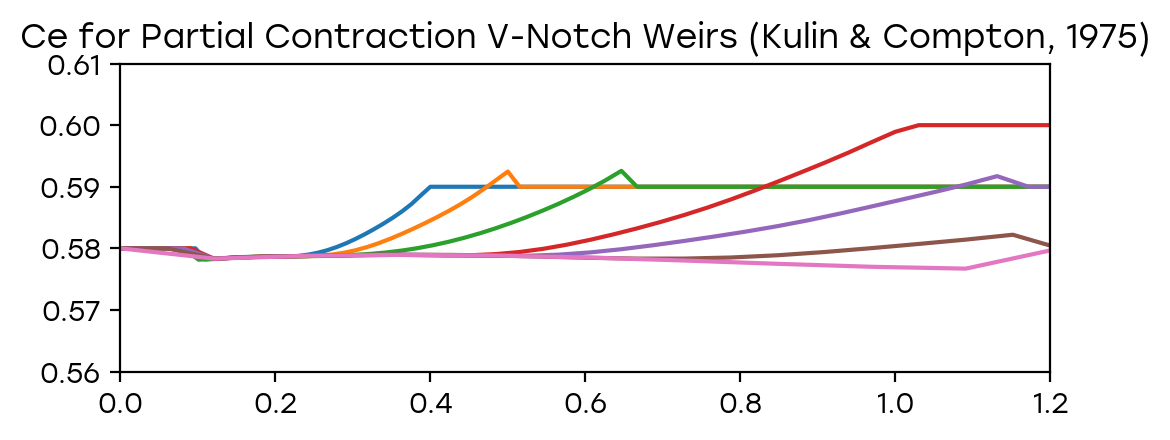

In [6]:
# check plots:
H_arr = np.linspace(0,12,100)

fig, ax = plt.subplots(figsize=(6,2))

# P/B 1.0
P = 10
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# P/B 0.8
P = 8
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# P/B 0.6
P = 6
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# P/B 0.4
P = 4
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# P/B 0.3
P = 3
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# P/B 0.2
P = 2
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# P/B 0.1
P = 1
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot)

# # P/B interpolation checks
# P = 1.5
# B = 10
# x_plot = H_arr/P
# y_plot = np.zeros(len(H_arr))
# for i in range(len(H_arr)):
#     # print('i = ', i)
#     H = H_arr[i]
#     y_plot[i] = Ce_part_vnotch(H,P,B)
#     # print('Ce = ', y_plot[i])
# plt.plot(x_plot, y_plot)

plt.title('Ce for Partial Contraction V-Notch Weirs (Kulin & Compton, 1975)')
plt.xlim([0,1.2])
plt.ylim([0.56,0.61])
plt.show()
plt.close()

In [7]:
# Q functions for weirs

def kh_vnotch_KC(angle_vnotch): # from Kulin and Compton 1975 - Fig 4-3
    return 0.0000000002853*angle_vnotch**4 - 0.0000000830929*angle_vnotch**3 + 0.0000097540537*angle_vnotch**2 - 0.0005756285132*angle_vnotch + 0.0174729907833

def Q_Kindsvater_Shen(angle_vnotch,h1,P,B): # from Kulin and Compton 1975 - Eq 4.4
    Ce = Ce_part_vnotch(h1,P,B)
    kh = kh_vnotch_KC(angle_vnotch)
    h1e = h1 + kh # head on weir, h1, plus head correction factor, kh
    if h1 <= 0: # if negative head means below weir crest, make flowrate zero
        Q = 0
    else:
        Q = 4.28*Ce*np.tan(angle_vnotch/2)*h1e**(5/2)
    return Q

def Ce_Phil(H): # uses Phil's jerry-rigged Excel polynomial curve fitting to find Ce coefficient
    return 0.0142*H**3 - 0.021*H**2 + 0.01*H + 0.5761



def Q_weir_Phil_frankenstein(P_vnotch,P_rect,Cw,L_rect,H): # uses Phil's frankenstein of rectangular and v-notch sharp-crested weir equations
    if H <= 0:
        Q_tot = 0
    elif H> 0 and H <= (P_rect-P_vnotch): 
        Ce = Ce_Phil(H)
        Q_tot = 4.28*Ce*(H+0.0029)**(5/2)
    else: # combined rectangular and vnotch
        Ce = Ce_Phil(H)
        Q_vnotch = 4.28*Ce*(H+0.0029)**(5/2)
        H_rect = H - (P_rect - P_vnotch)
        Q_rect = Cw*L_rect*H_rect**1.5
        Q_tot = Q_vnotch+Q_rect
    return Q_tot

def Q_weir_Phil_frankenstein_alt1(P_vnotch,P_rect,Cw,L_rect,H): # uses Phil's frankenstein of rectangular and v-notch sharp-crested weir equations
    if H <= 0:
        Q_tot = 0
    elif H> 0 and H <= (P_rect-P_vnotch): 
        Q_tot = Q_Kindsvater_Shen(90,H,P_vnotch,4)
    else: # combined rectangular and vnotch
        Q_vnotch = Q_Kindsvater_Shen(90,H,P_vnotch,4)
        H_rect = H - (P_rect - P_vnotch)
        Q_rect = Cw*L_rect*H_rect**1.5
        Q_tot = Q_vnotch+Q_rect
    return Q_tot

def Q_Bergmann(hm,P_rect,P_vnotch,units_str,b): # Bergmann 1963 from USBR Water Msmt Manual 1997 and Quebec Ministry of the Environment 2007 - for combination v-notch/rectangular weirs - might be only for fully contracted v-notch weirs?
    # Q = C*ht**1.72 - d + e*b*hr # original Bergmann Eq - collapses to Cone Eq at H <=1 ft, just v-notch, hr=hm-ht
    ht = (P_rect-P_vnotch)
    hr = hm-ht
    if units_str == 'Imperial':
        C = 3.9
        d = 1.5
        e = 3.3
    elif units_str == 'SI':
        C = 5.2
        d = 1.5
        e = 1.82
    else:
        print('Error: no units system specified.')
    if hm <= 0:
        Q_tot = 0
    else:
        Q_tot = C*ht**1.72 - d + e*b*hr
    return Q_tot

def Q_Sam_frankenstein(hm,P_rect,P_vnotch,B,angle_vnotch,units_str,b): # Sam's frankenstein - combines Kindsvater-Shen for when flows only in v-notch, then Bergmann 1963 combined equation when above rectanglular crest
    # Q = C*ht**1.72 - d + e*b*hr # original Bergmann Eq - collapses to Cone Eq at H <=1 ft, just v-notch, hr=hm-ht
    if hm <= 0:
        Q_tot = 0
    elif hm > 0 and hm <= (P_rect-P_vnotch):
        Q_tot = Q_Kindsvater_Shen(angle_vnotch,hm,P_vnotch,B)
    else: # Bergmann 1963 from USBR Water Msmt Manual 1997 and Quebec Ministry of the Environment 2007 - for combination v-notch/rectangular weirs - might be only for fully contracted v-notch weirs?
        # Q_tot = Q_Bergmann(hm,P_rect,P_vnotch,units_str,b)
        Q_vnotch = Q_Kindsvater_Shen(angle_vnotch,(P_rect-P_vnotch),P_vnotch,B)
        ht = (P_rect-P_vnotch)
        hr = hm-ht
        if units_str == 'Imperial':
            C = 3.9
            d = 1.5
            e = 3.3
        elif units_str == 'SI':
            C = 5.2
            d = 1.5
            e = 1.82
        else:
            print('Error: no units system specified.')
        Q_tot = Q_vnotch + e*b*hr
    return Q_tot

def Q_Sam_frankenstein_alt1(hm,P_rect,P_vnotch,B,angle_vnotch,units_str,b): # Sam's frankenstein - combines Kindsvater-Shen for when flows only in v-notch, then Bergmann 1963 combined equation when above rectanglular crest
    # Q = C*ht**1.72 - d + e*b*hr # original Bergmann Eq - collapses to Cone Eq at H <=1 ft, just v-notch, hr=hm-ht
    if hm <= 0:
        Q_tot = 0
    elif hm > 0 and hm <= (P_rect-P_vnotch):
        Q_tot = Q_Kindsvater_Shen(angle_vnotch,hm,P_vnotch,B)
    else: # Bergmann 1963 from USBR Water Msmt Manual 1997 and Quebec Ministry of the Environment 2007 - for combination v-notch/rectangular weirs - might be only for fully contracted v-notch weirs?
        Q_tot = Q_Bergmann(hm,P_rect,P_vnotch,units_str,b)
    return Q_tot

def Q_Sam_frankenstein_alt2(hm,P_rect,P_vnotch,B,angle_vnotch,units_str,b): # Sam's frankenstein - combines Kindsvater-Shen for when flows only in v-notch, then Bergmann 1963 combined equation when above rectanglular crest
    # Q = C*ht**1.72 - d + e*b*hr # original Bergmann Eq - collapses to Cone Eq at H <=1 ft, just v-notch, hr=hm-ht
    if hm <= 0:
        Q_tot = 0
    elif hm > 0 and hm <= (P_rect-P_vnotch):
        Q_tot = Q_Kindsvater_Shen(angle_vnotch,hm,P_vnotch,B)
    else: # Bergmann 1963 from USBR Water Msmt Manual 1997 and Quebec Ministry of the Environment 2007 - for combination v-notch/rectangular weirs - might be only for fully contracted v-notch weirs?
        # Q_tot = Q_Bergmann(hm,P_rect,P_vnotch,units_str,b)
        Q_vnotch = Q_Kindsvater_Shen(angle_vnotch,(P_rect-P_vnotch),P_vnotch,B)
        ht = (P_rect-P_vnotch)
        hr = hm-ht
        if units_str == 'Imperial':
            C = 3.9
            d = 1.5
            e = 3.3
        elif units_str == 'SI':
            C = 5.2
            d = 1.5
            e = 1.82
        else:
            print('Error: no units system specified.')
        Q_tot = Q_vnotch - d + e*b*hr
    return Q_tot

def Q_Sam_frankenstein_alt2(hm,P_rect,P_vnotch,B,angle_vnotch,units_str,b): # Sam's frankenstein - combines Kindsvater-Shen for when flows only in v-notch, then Bergmann 1963 combined equation when above rectanglular crest
    # Q = C*ht**1.72 - d + e*b*hr # original Bergmann Eq - collapses to Cone Eq at H <=1 ft, just v-notch, hr=hm-ht
    if hm <= 0:
        Q_tot = 0
    elif hm > 0 and hm <= (P_rect-P_vnotch):
        Q_tot = Q_Kindsvater_Shen(angle_vnotch,hm,P_vnotch,B)
    else: # Bergmann 1963 from USBR Water Msmt Manual 1997 and Quebec Ministry of the Environment 2007 - for combination v-notch/rectangular weirs - might be only for fully contracted v-notch weirs?
        # Q_tot = Q_Bergmann(hm,P_rect,P_vnotch,units_str,b)
        Q_vnotch = Q_Kindsvater_Shen(angle_vnotch,(P_rect-P_vnotch),P_vnotch,B)
        ht = (P_rect-P_vnotch)
        hr = hm-ht
        if units_str == 'Imperial':
            C = 3.9
            d = 1.5
            e = 3.3
        elif units_str == 'SI':
            C = 5.2
            d = 1.5
            e = 1.82
        else:
            print('Error: no units system specified.')
        Q_tot = Q_vnotch + e*b*hr
    return Q_tot

def Q_Holly_frankenstein(hm,P_rect,P_vnotch,B,angle_vnotch): # Holly's frankenstein - combines Kindsvater-Shen for when flows only in v-notch, FHWA's HY-8 stage-discharge curve for headwater of culvert minus HY-8 discharge at top of v-notch
    if hm <= 0:
        Q_tot = 0
    elif hm > 0 and hm <= (P_rect-P_vnotch):
        Q_tot = Q_Kindsvater_Shen(angle_vnotch,hm,P_vnotch,B)
    else: # uses stage-discharge curve made from HY-8, subtracts the flow at this depth in a 4' culvert from the flow at the depth of the top of v-notch in 4' Givens culvert
        Q_vnotch = Q_Kindsvater_Shen(angle_vnotch,(P_rect-P_vnotch),P_vnotch,B)
        Q_HY8 = 7.8791*(hm+4/12)**1.6098
        Q_HY8_topvnotch = 20.55 # cfs from HY8 at top of v-notch: 1.5ft plus 4in between v-notch crest and invert of culvert
        Q_top = Q_HY8 - Q_HY8_topvnotch
        Q_tot = Q_vnotch+Q_top
    return Q_tot

# vectorize the functions so they can be performed on whole arrays:
kh_vnotch_KC = np.vectorize(kh_vnotch_KC)
Q_Kindsvater_Shen = np.vectorize(Q_Kindsvater_Shen)
Ce_Phil = np.vectorize(Ce_Phil)
Q_weir_Phil_frankenstein = np.vectorize(Q_weir_Phil_frankenstein)
Q_Bergmann = np.vectorize(Q_Bergmann)
Q_Sam_frankenstein = np.vectorize(Q_Sam_frankenstein)
Q_Holly_frankenstein = np.vectorize(Q_Holly_frankenstein)

# if P < 2*H:
#     print('Warning: P < 2*H.')
# elif P < 0.2: # 0.2 ft:
#     print('Warning: P < 0.2 ft below crest.')
# elif H/P > 5: 
#     print('Warning: H/P > 5, weir is "no longer control section" (Sturm, 2001).')
# elif H > 2: # 2 ft
#     print('Warning: max head over partially-contracted v-notch of 2 ft exceeded.')
# else:
#     pass

In [8]:
# calcs

# Givens Estates weir dimensions
P_vnotch = 6/12 # ft, US vertical height of v-crest over US bed
B = 4 # ft, top width of entire weir's lateral span
L_rect = 5.5*2/12 # length of rectangular weir crest portion, not including v-notch horizontal length
Cw = 3.33 # sharp-crested rect weir coefficient
P_rect = 1.5 + 6/12 # ft, US vertical height of rectangular crest over US bed
angle_vnotch = 90 # needs to be in degrees for kh eqn
units_str = 'Imperial' # input unit system for proper coefficients and intercepts - input either 'Imperial' or 'SI'
b = B # width of rectangular section is whole width of channel (sorta like a 'suppressed' or full channel width rectangular weir)

# discharge calcs
stage_sed_df['Q_cfs_PhilFrank'] = Q_weir_Phil_frankenstein(P_vnotch,P_rect,Cw,L_rect,stage_sed_df['stage_corrected_ft'])
stage_sed_df['Q_cfs_Bergmann'] = Q_Bergmann(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,units_str,b)
stage_sed_df['Q_cfs_SamFrank'] = Q_Sam_frankenstein(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,B,angle_vnotch,units_str,b)
stage_sed_df['Q_cfs_HollyFrank'] = Q_Holly_frankenstein(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,B,angle_vnotch)

# sed calcs
# stage_sed_df['Sed_Conc_mg_L'] = stage_sed_df['Sed_Wt_g']/stage_sed_df['Vol_Tot_mL']*1000**2 # concentration from g/mL to mg/L
# ^ conc should be already calculated in combining stage_df and sed_df
stage_sed_df['load_g_s_PhilFrank'] = stage_sed_df['conc_mg_L']*(28.317/1000)*stage_sed_df['Q_cfs_PhilFrank'] # convert mg/L to g/ft^3
stage_sed_df['load_g_s_SamFrank'] = stage_sed_df['conc_mg_L']*(28.317/1000)*stage_sed_df['Q_cfs_SamFrank'] # convert mg/L to g/ft^3
stage_sed_df['load_g_s_HollyFrank'] = stage_sed_df['conc_mg_L']*(28.317/1000)*stage_sed_df['Q_cfs_HollyFrank'] # convert mg/L to g/ft^3

# save df to csv
stage_sed_df.to_csv('stage_sed_flow_combine.csv', index=False)

display(stage_sed_df)


,date_time_stage,stage_raw,stage_corrected_ft,date_time_isco,conc_mg_L,Q_cfs_PhilFrank,Q_cfs_Bergmann,Q_cfs_SamFrank,Q_cfs_HollyFrank,load_g_s_PhilFrank,load_g_s_SamFrank,load_g_s_HollyFrank
0,2018-04-15 08:23:00,4.0000,0.333333,2018-04-15 08:23:00,355.526316,0.162066,-9.066757,0.262660,0.262660,1.631591,2.644317,2.644317
1,2018-04-15 09:51:00,10.0000,0.833333,2018-04-15 09:51:00,1578.807947,1.582126,-2.466757,2.570625,2.570625,70.732275,114.925223,114.925223
2,2018-04-15 10:11:00,19.5000,1.625000,2018-04-15 10:11:00,3535.745614,8.786380,7.983243,12.782495,13.828894,879.707376,1279.805281,1384.572535
3,2018-04-15 10:20:00,15.5000,1.291667,2018-04-15 10:20:00,8377.412281,4.770895,3.583243,7.666000,7.666000,1131.766967,1818.553026,1818.553026
4,2018-04-15 10:30:00,13.0000,1.083333,2018-04-15 10:30:00,3350.000000,3.054466,0.833243,4.943704,4.943704,289.752571,468.969362,468.969362
...,...,...,...,...,...,...,...,...,...,...,...,...
184772,2024-08-20 08:51:13,0.1164,0.116400,NaT,NaN,0.012140,-11.930277,0.019690,0.019690,NaN,NaN,NaN
184773,2024-08-20 08:56:13,0.1129,0.112900,NaT,NaN,0.011269,-11.976477,0.018276,0.018276,NaN,NaN,NaN
184774,2024-08-20 09:01:13,0.1090,0.109000,NaT,NaN,0.010343,-12.027957,0.016774,0.016774,NaN,NaN,NaN
184775,2024-08-20 09:06:13,0.1152,0.115200,NaT,NaN,0.011837,-11.946117,0.019198,0.019198,NaN,NaN,NaN


In [9]:
# check when v-notch of weir is overtopped and flow spills onto horizontal crest wings
overtop_df = stage_sed_df[stage_sed_df['stage_corrected_ft'] > 1.5]
overtop_df = overtop_df.dropna(subset=['date_time_isco'])

display(overtop_df)

,date_time_stage,stage_raw,stage_corrected_ft,date_time_isco,conc_mg_L,Q_cfs_PhilFrank,Q_cfs_Bergmann,Q_cfs_SamFrank,Q_cfs_HollyFrank,load_g_s_PhilFrank,load_g_s_SamFrank,load_g_s_HollyFrank
2,2018-04-15 10:11:00,19.500000,1.625000,2018-04-15 10:11:00,3535.745614,8.786380,7.983243,12.782495,13.828894,879.707376,1279.805281,1384.572535
26263,2019-04-19 11:14:47,1.622532,1.652532,2019-04-19 11:15:00,860.957179,9.226863,8.346665,13.145918,14.357258,224.948385,320.493857,350.026003
26443,2019-04-19 14:14:47,1.541340,1.571340,2019-04-19 14:15:00,951.282051,7.977313,7.274930,12.074183,12.812096,214.888512,325.247756,345.125236
26508,2019-04-19 15:19:47,1.689830,1.719830,2019-04-19 15:20:00,844.642857,10.374795,9.234998,14.034251,15.667602,248.141775,335.667725,374.733807
26520,2019-04-19 15:31:47,1.687869,1.717869,2019-04-19 15:32:00,991.206030,10.339915,9.209113,14.008366,15.629044,290.220529,393.186542,438.675703
26543,2019-04-19 15:54:47,1.527126,1.557126,2019-04-19 15:55:00,387.559809,7.774302,7.087305,11.886558,12.545649,85.319323,130.449401,137.682615
26553,2019-04-19 16:04:47,1.472857,1.502857,2019-04-19 16:05:00,270.048309,7.048658,6.370955,11.170208,11.539602,53.900789,85.418110,88.242851
128540,2024-05-18 17:42:49,1.615300,1.615300,2024-05-18 17:42:00,1212.500000,8.635248,7.855203,12.654455,13.643816,296.485741,434.482660,468.451722


In [19]:
# automate finding sediment events?
# for idx, row in stage_sed_df.iterrows():

# enter sediment events manually:
event_1_start = '2018-04-15 07:50:00'
event_1_end = '2018-04-15 17:00:00'

event_2_start = '2018-04-23 07:00:00'
event_2_end = '2018-04-23 16:30:00'

event_3_start = '2018-04-24 07:00:00'
event_3_end = '2018-04-24 10:30:00'

event_4_start = '2018-04-26 14:00:00'
event_4_end = '2018-04-27 01:00:00'

event_5_start = '2018-05-06 03:00:00'
event_5_end = '2018-05-06 04:30:00'

event_6_start = '2018-05-07 19:00:00'
event_6_end = '2018-05-07 20:10:00'

event_7_start = '2018-05-16 11:00:00'
event_7_end = '2018-05-16 15:00:00'

event_8_start = '2019-04-18 22:50:00'
event_8_end = '2019-04-19 20:00:00'

event_9_start = '2019-07-15 18:00:00'
event_9_end = '2019-07-15 19:30:00'

event_10_start = '2019-07-16 13:00:00'
event_10_end = '2019-07-16 19:00:00'

event_11_start = '2019-07-23 06:30:00'
event_11_end = '2019-07-23 16:00:00'

event_12_start = '2023-07-15 18:00:00'
event_12_end = '2023-07-16 00:00:00'

event_13_start = '2023-08-29 00:00:00'
event_13_end = '2023-08-30 10:00:00'

event_14_start = '2024-05-17 15:00:00'
event_14_end = '2024-05-17 17:20:00' 

event_15_start = '2024-05-18 16:50:00'
event_15_end = '2024-05-18 20:00:00'

event_16_start = '2024-05-23 20:30:00' 
event_16_end = '2024-05-24 00:00:00'

event_17_start = '2024-07-07 13:00:00'
event_17_end = '2024-07-07 18:00:00'

event_18_start = '2024-07-16 18:00:00'
event_18_end = '2024-07-16 20:00:00'

event_19_start = '2024-07-17 20:00:00'
event_19_end = '2024-07-17 22:00:00' 

event_20_start = '2024-07-18 17:00:00'
event_20_end = '2024-07-18 18:00:00' 

event_21_start = '2024-07-24 18:00:00'
event_21_end = '2024-07-25 00:00:00'

event_22_start = '2024-07-19 16:00:00'
event_22_end = '2024-07-19 18:00:00' 

event_23_start = '2024-07-20 17:00:00'
event_23_end = '2024-07-20 21:00:00'

event_24_start = '2024-08-02 14:00:00'
event_24_end = '2024-08-02 17:00:00' 

event_25_start = '2024-08-17 15:00:00' 
event_25_end = '2024-08-17 22:00:00'

events_nested_pairs = np.array([
    [event_1_start,event_1_end],
    [event_2_start,event_2_end],
    [event_3_start,event_3_end],
    [event_4_start,event_4_end],
    [event_5_start,event_5_end],
    [event_6_start,event_6_end],
    [event_7_start,event_7_end],
    [event_8_start,event_8_end],
    [event_9_start,event_9_end],
    [event_10_start,event_10_end],
    [event_11_start,event_11_end],
    [event_12_start,event_12_end],
    [event_13_start,event_13_end],
    [event_14_start,event_14_end],
    [event_15_start,event_15_end],
    [event_16_start,event_16_end],
    [event_17_start,event_17_end],
    [event_18_start,event_18_end],
    [event_19_start,event_19_end],
    [event_20_start,event_20_end],
    [event_21_start,event_21_end],
    [event_22_start,event_22_end],
    [event_23_start,event_23_end],
    [event_24_start,event_24_end],
    [event_25_start,event_25_end],
])

def plot_event_compareQ(stage_sed_df, event_start, event_end):
    # filter master df to only be during event timespan
    event_df = stage_sed_df[(stage_sed_df['date_time_stage'] >= event_start) & (stage_sed_df['date_time_stage'] <= event_end)]
    # make sediment data continuous by dropping stage timestamps it didn't record for
    event_df_sed = event_df.dropna(subset=['conc_mg_L'])
    # display(event_df)
    # Q_trans = Q_Sam_frankenstein((P_rect-P_vnotch),P_rect,P_vnotch,B,angle_vnotch,units_str,b)


    # plot just discharge time series
    fig3, ax1 = plt.subplots()

    # plot discharge vs. sed load with multiple weir equations
    # plot flow on first y-axis
    line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {} DISCHARGE'.format(event_start))
    plt.show()
    # plt.close()


    # plot discharge vs. sed load time series
    fig1, ax1 = plt.subplots()

    # plot discharge vs. sed load with multiple weir equations
    # plot flow on first y-axis
    # line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    # line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    # line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    line1, = ax1.plot(event_df['date_time_stage'], event_df['Q_cfs_HollyFrank'], ls='-', color='tab:blue', alpha=0.8, label='Discharge')
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # plot sediment load on second y-axis
    ax2 = ax1.twinx()
    # line4, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_SamFrank'], ls='--', color='tab:blue', alpha=0.7, label='Qs Sam') # marker='s'
    # line5, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:orange', alpha=0.7, label='Qs Holly') # marker='s'
    # line6, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_PhilFrank'], ls='--', color='tab:grey', alpha=0.5, label='Qs Phil') # marker='s' # plot old method
    line2, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:brown', alpha=0.8, label='Sediment Load')
    ax2.set_ylabel('Load [g/s]') #, color='tab:orange')
    ax2.tick_params(axis='y') # , labelcolor='tab:orange')
    # Formatting the x-axis to show only the time
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    # lines = [line1, line2, line3, line4, line5, line6]
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {} LOAD'.format(event_start))
    plt.show()
    # plt.close()


    # plot discharge vs. stage time series
    fig2, ax1 = plt.subplots()

    # plot flow on first y-axis
    line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # plot stage on second y-axis
    ax2 = ax1.twinx()
    line4, = ax2.plot(event_df['date_time_stage'],event_df['stage_corrected_ft'], ls='--', color='tab:green', label='Stage') # marker='s'
    ax2.set_ylabel('Stage [ft]') #, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    # Formatting the x-axis to show only the time
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    lines = [line1, line2, line3, line4]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {} STAGE-DISCHARGE'.format(event_start))
    plt.show()
    # plt.close()
    
    return fig1, fig2, fig3

# for i_event in range(len(events_nested_pairs)):
#     event = events_nested_pairs[i_event]
#     event_start = pd.Timestamp(str(event[0]))
#     event_end = pd.Timestamp(str(event[1]))

#     plot_event_compareQ(stage_sed_df, event_start, event_end)
#     # fig = plot_event(stage_sed_df, event_start, event_end)
#     # plt.show()
#     # plt.close()

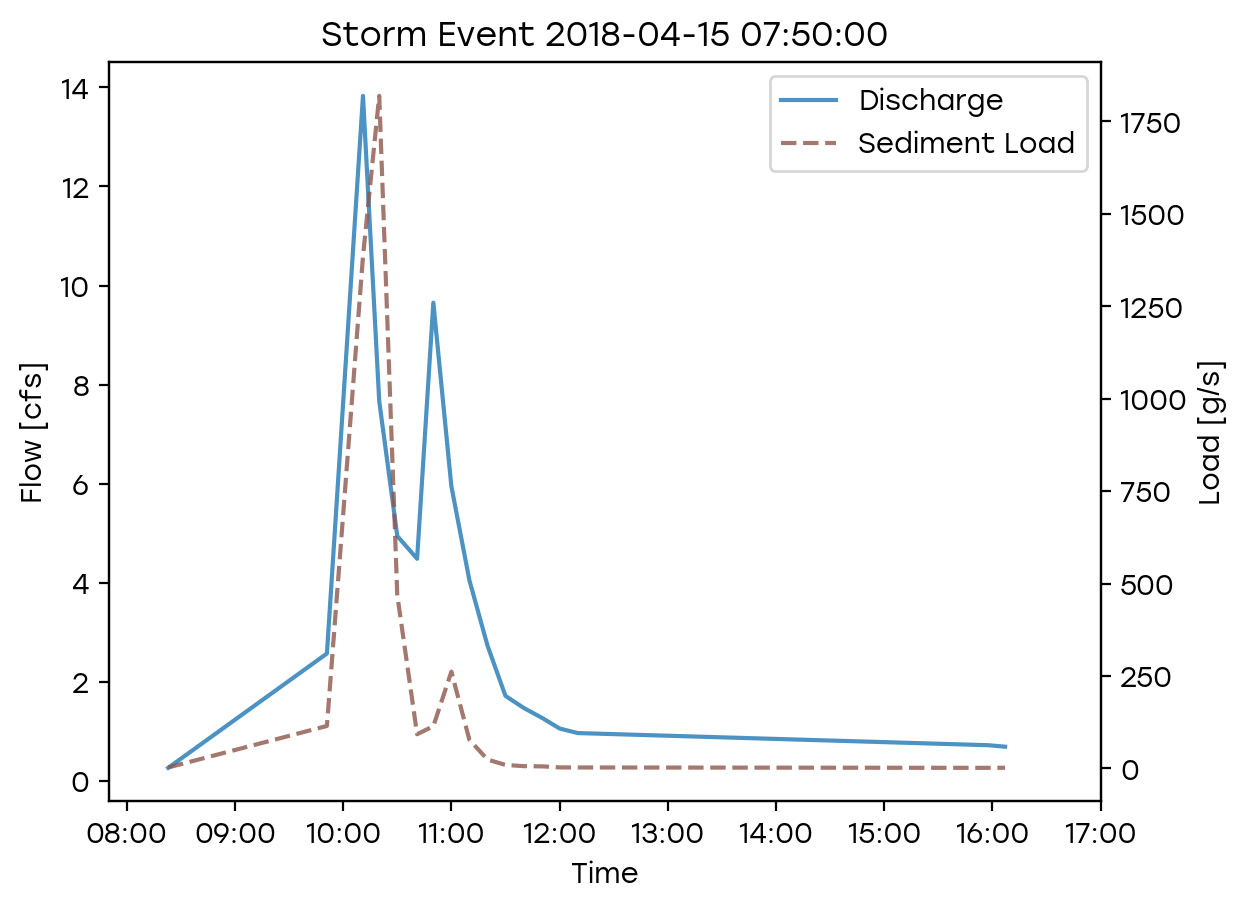

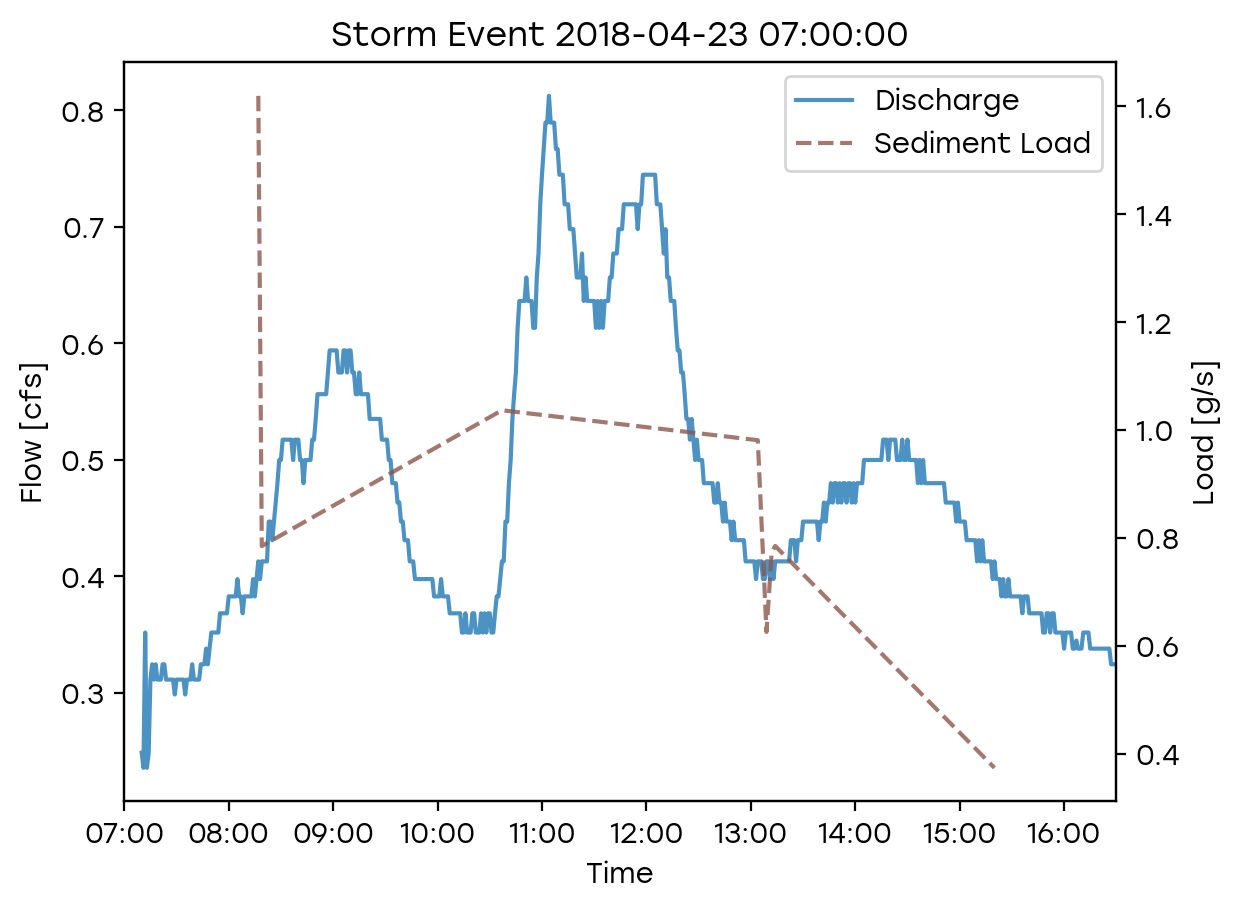

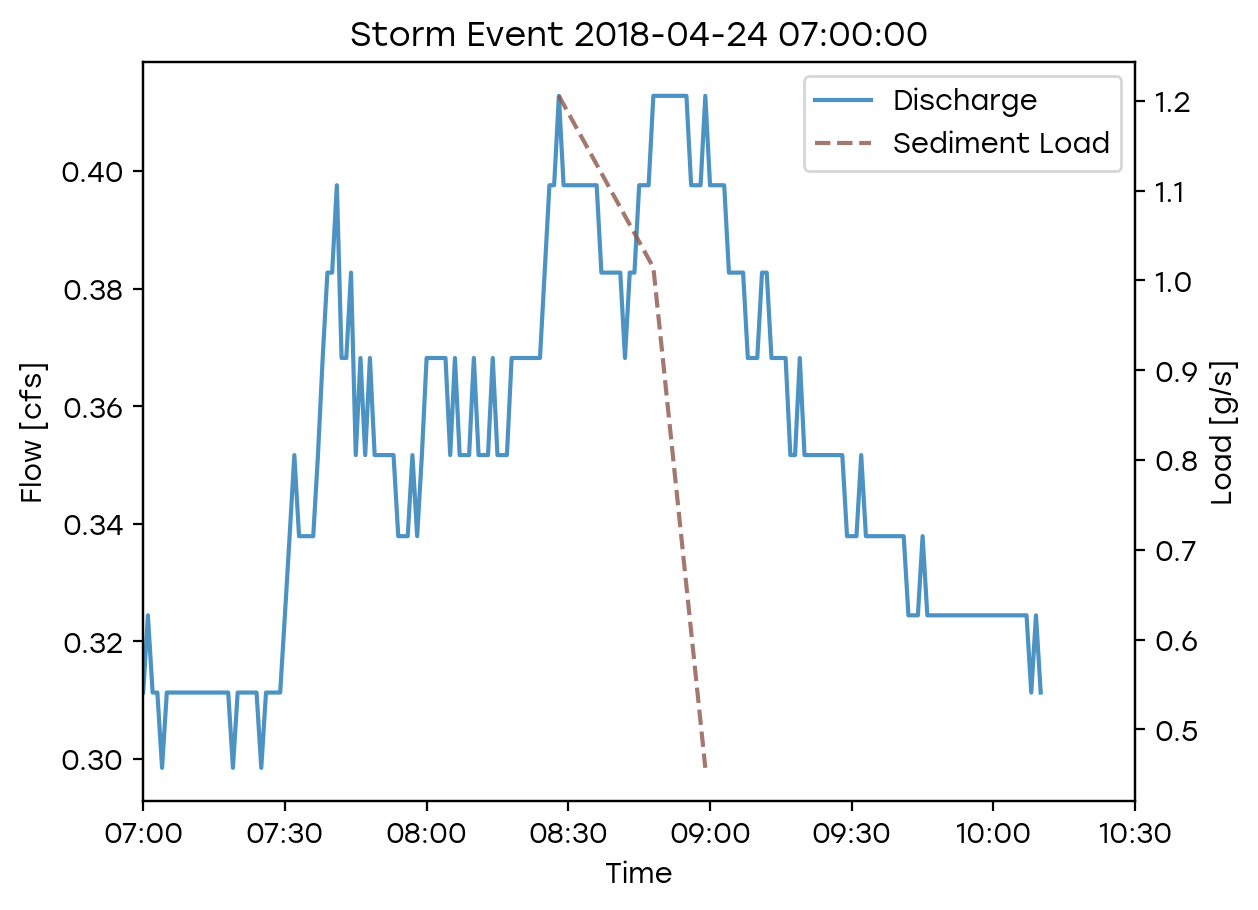

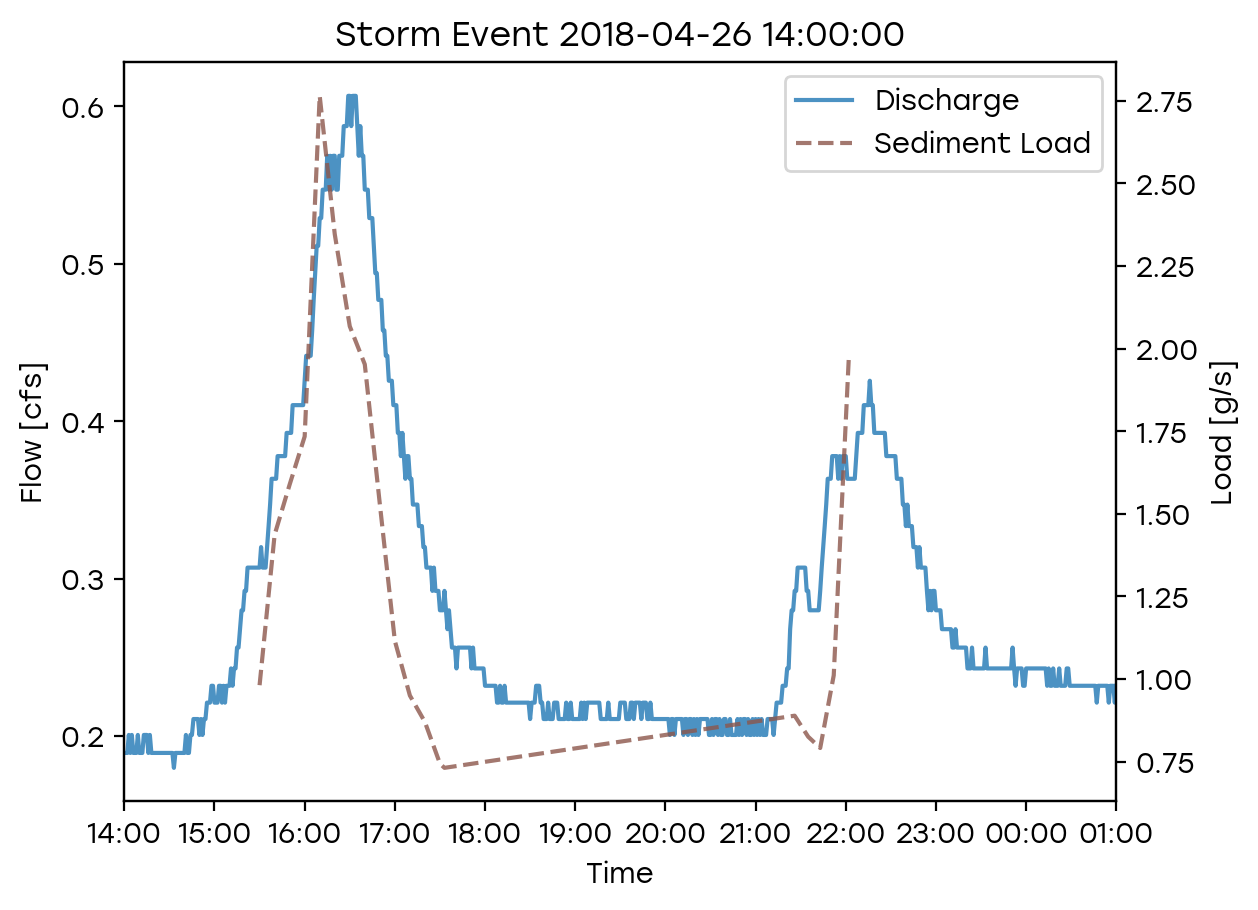

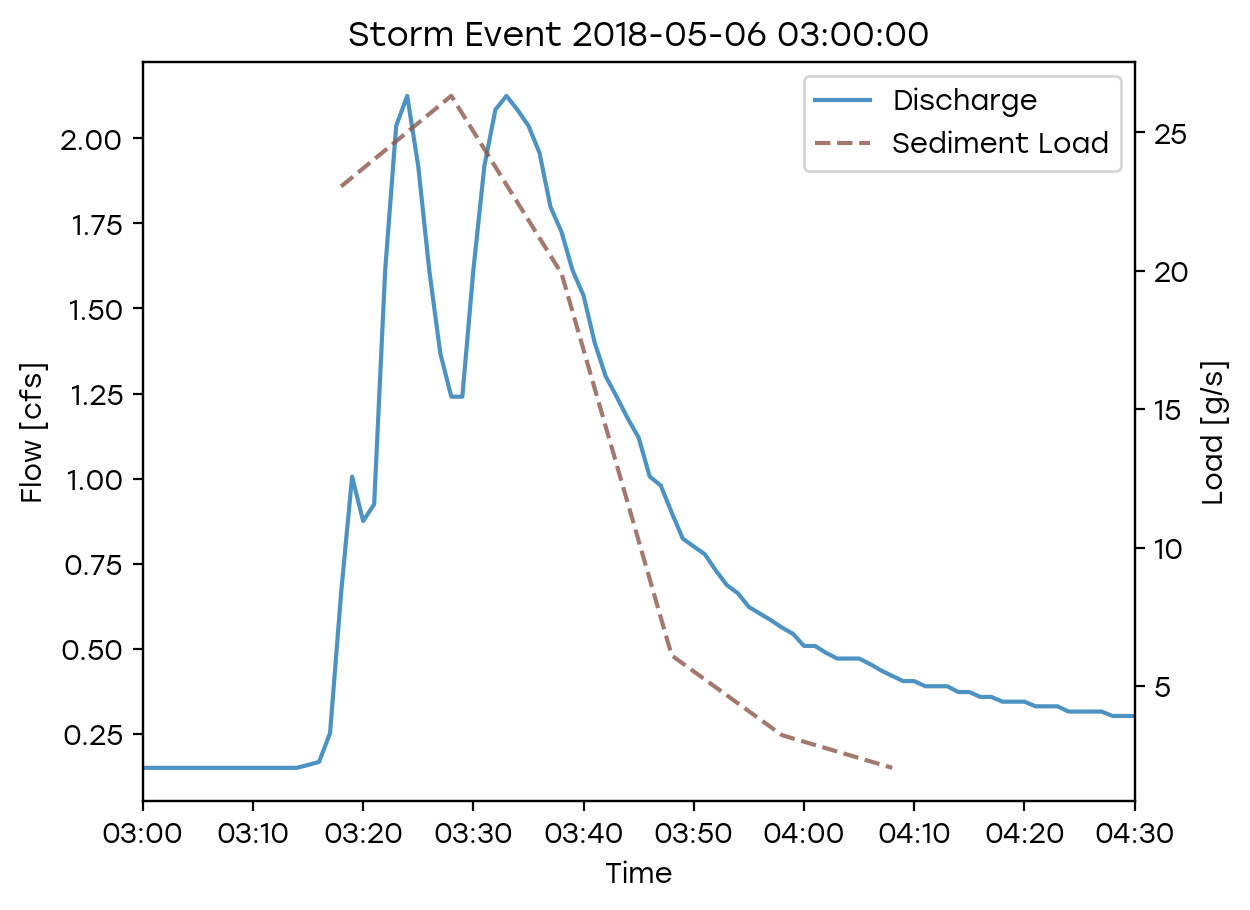

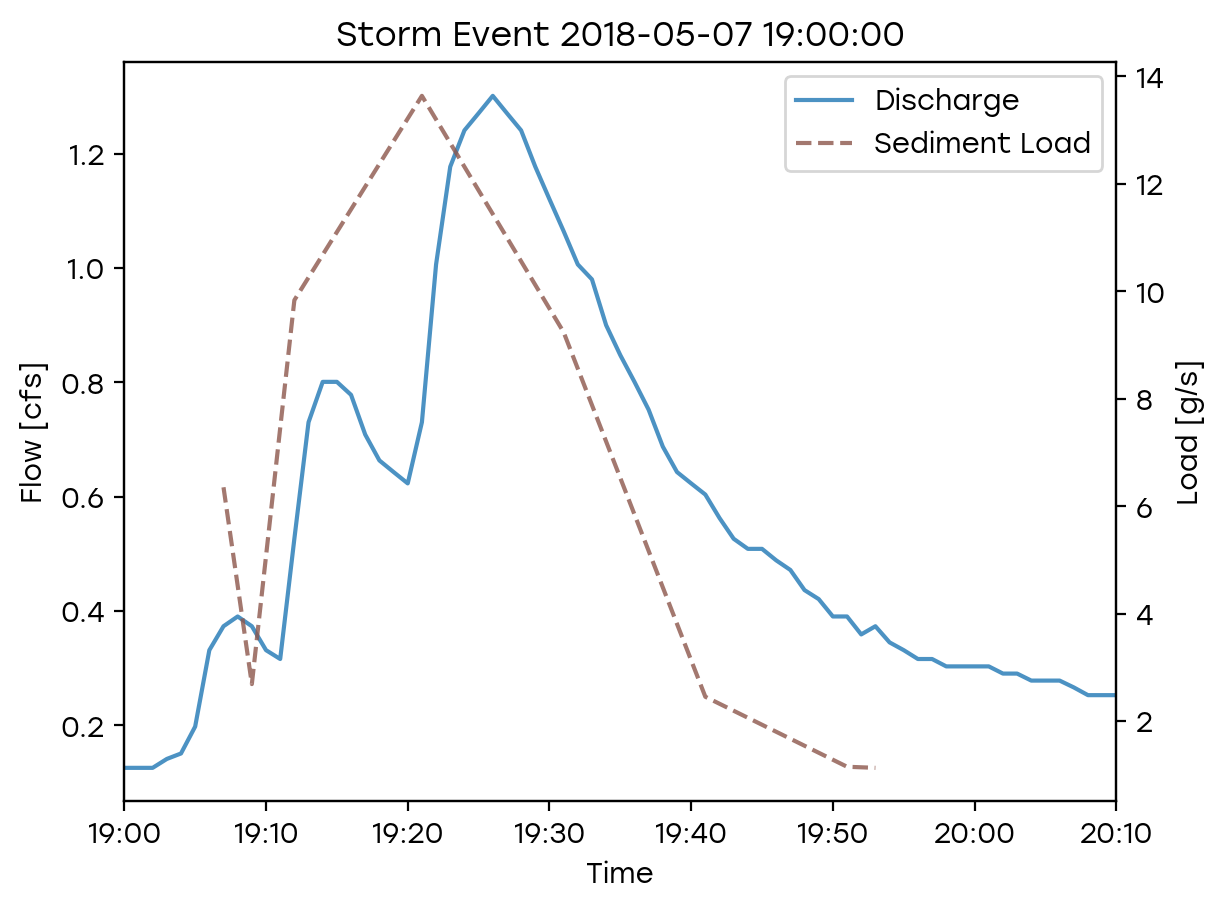

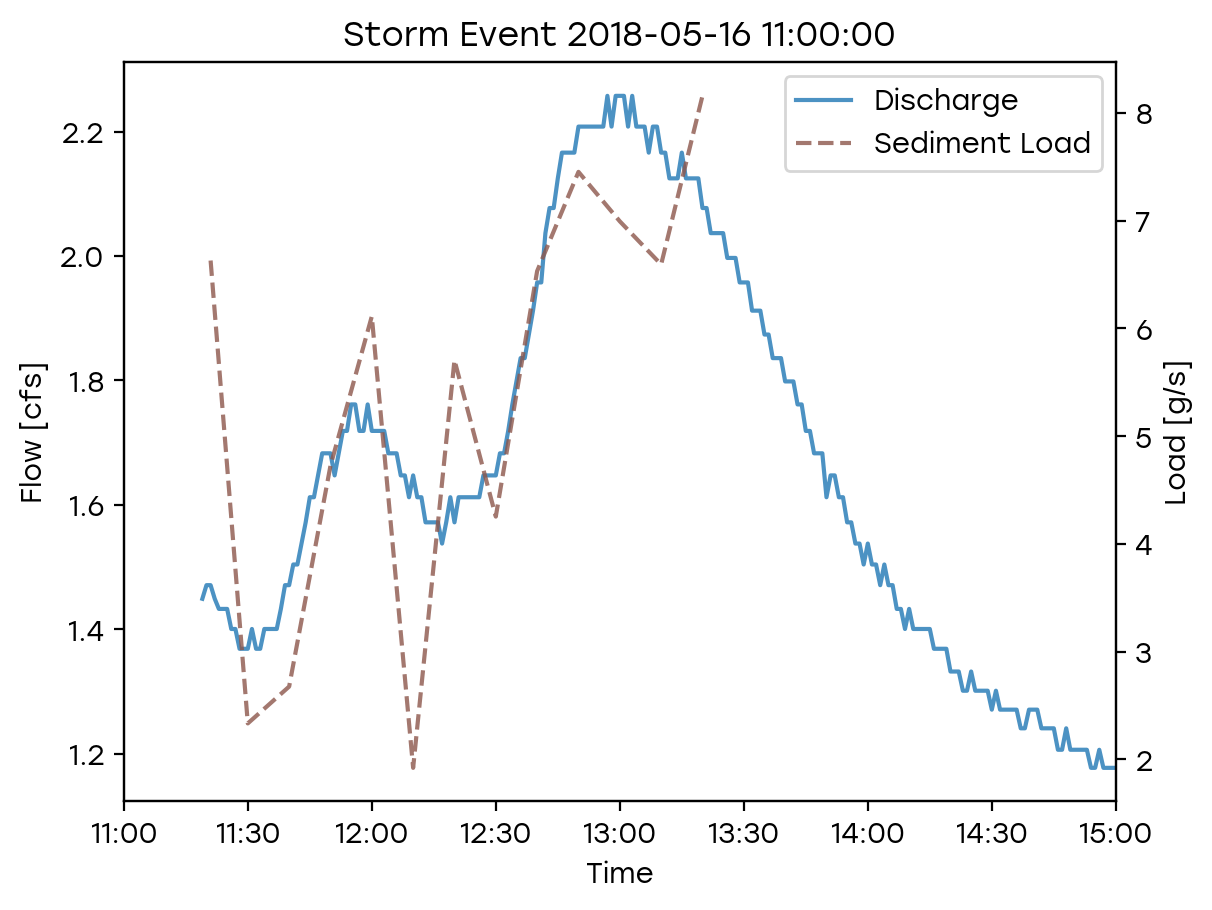

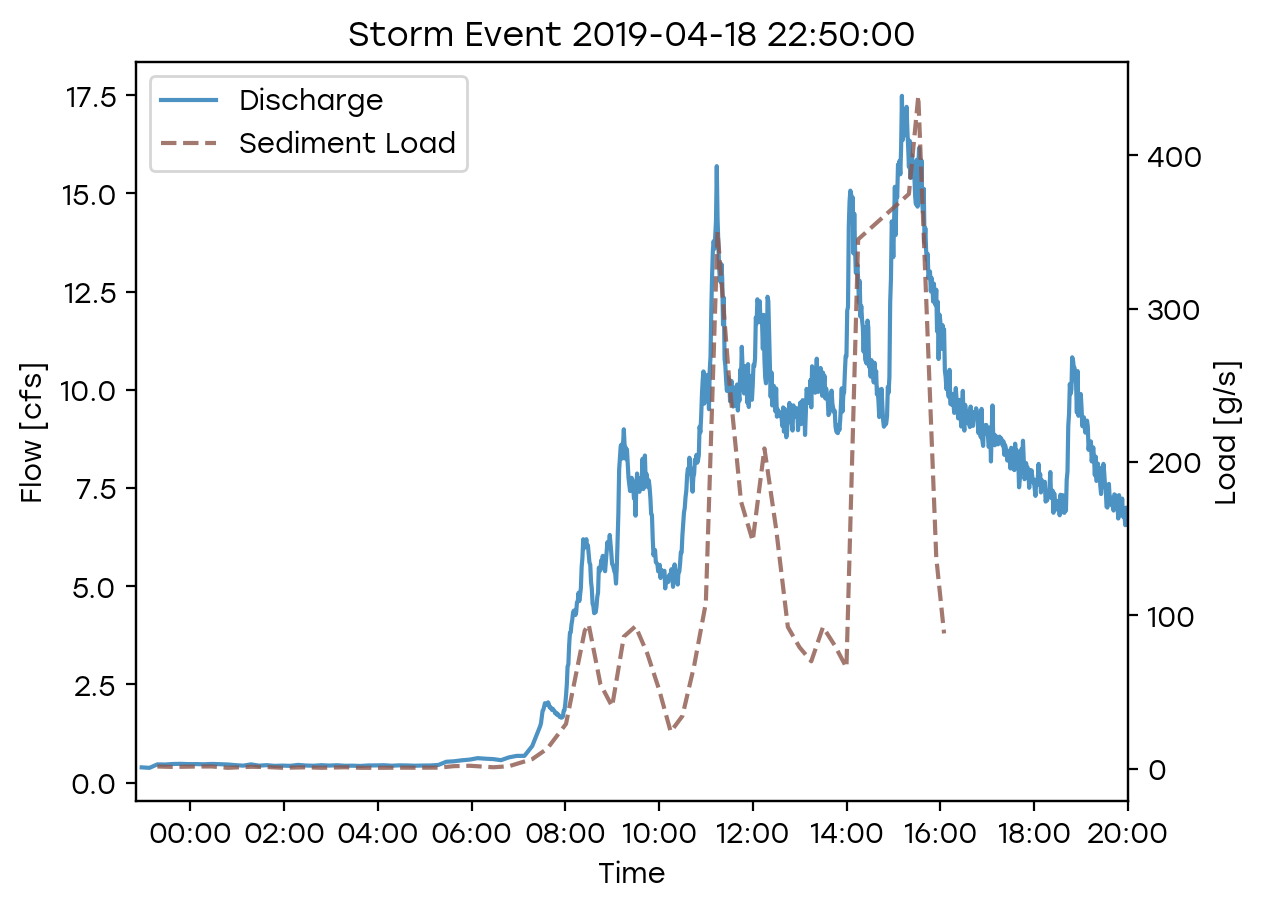

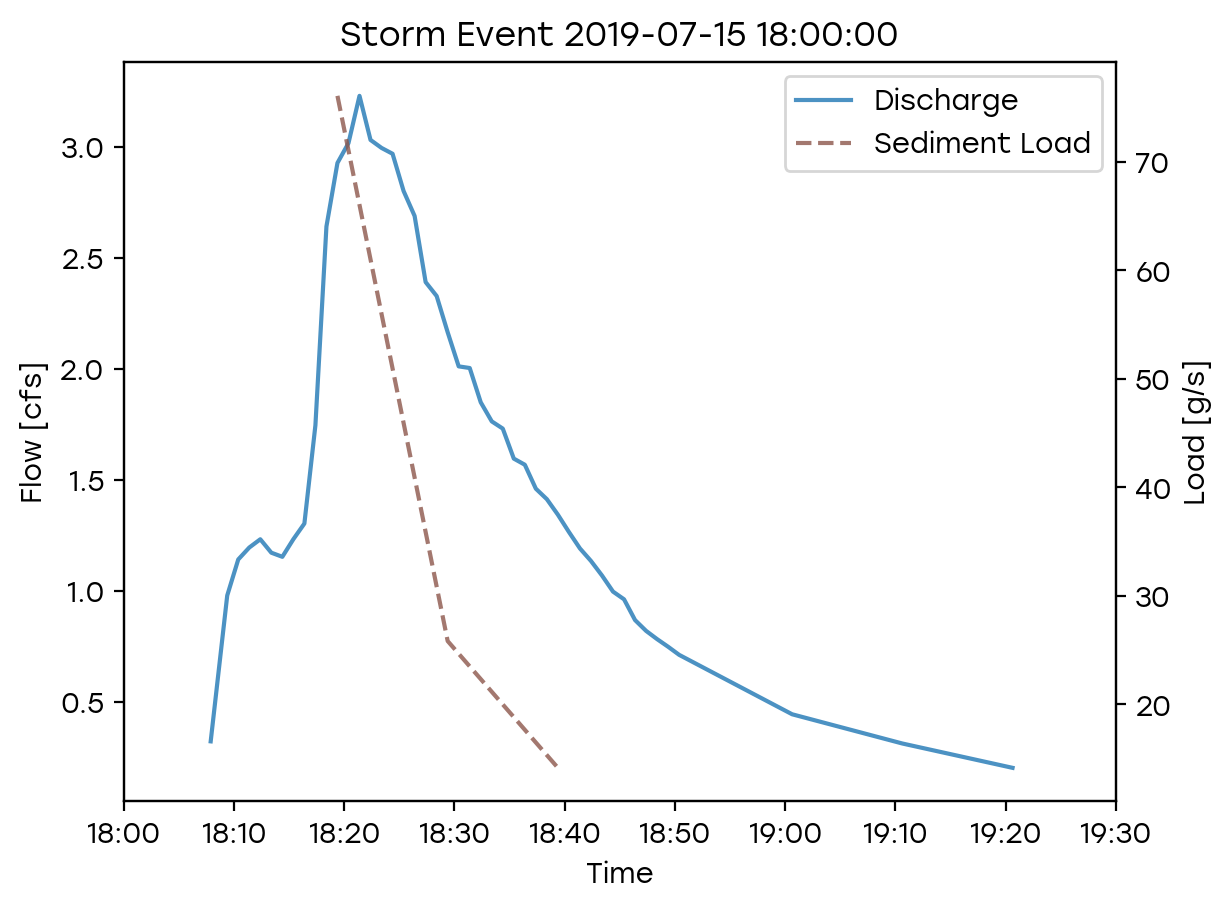

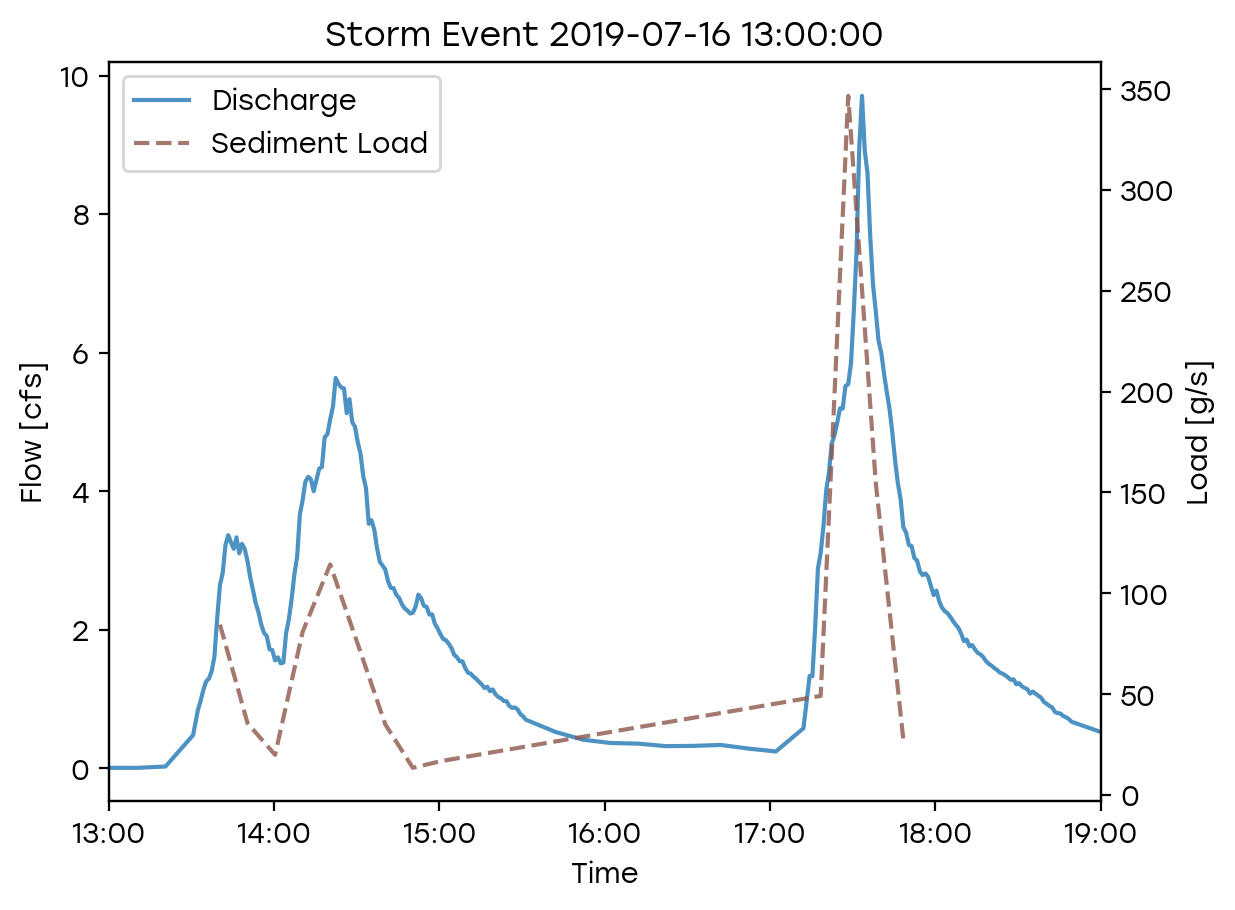

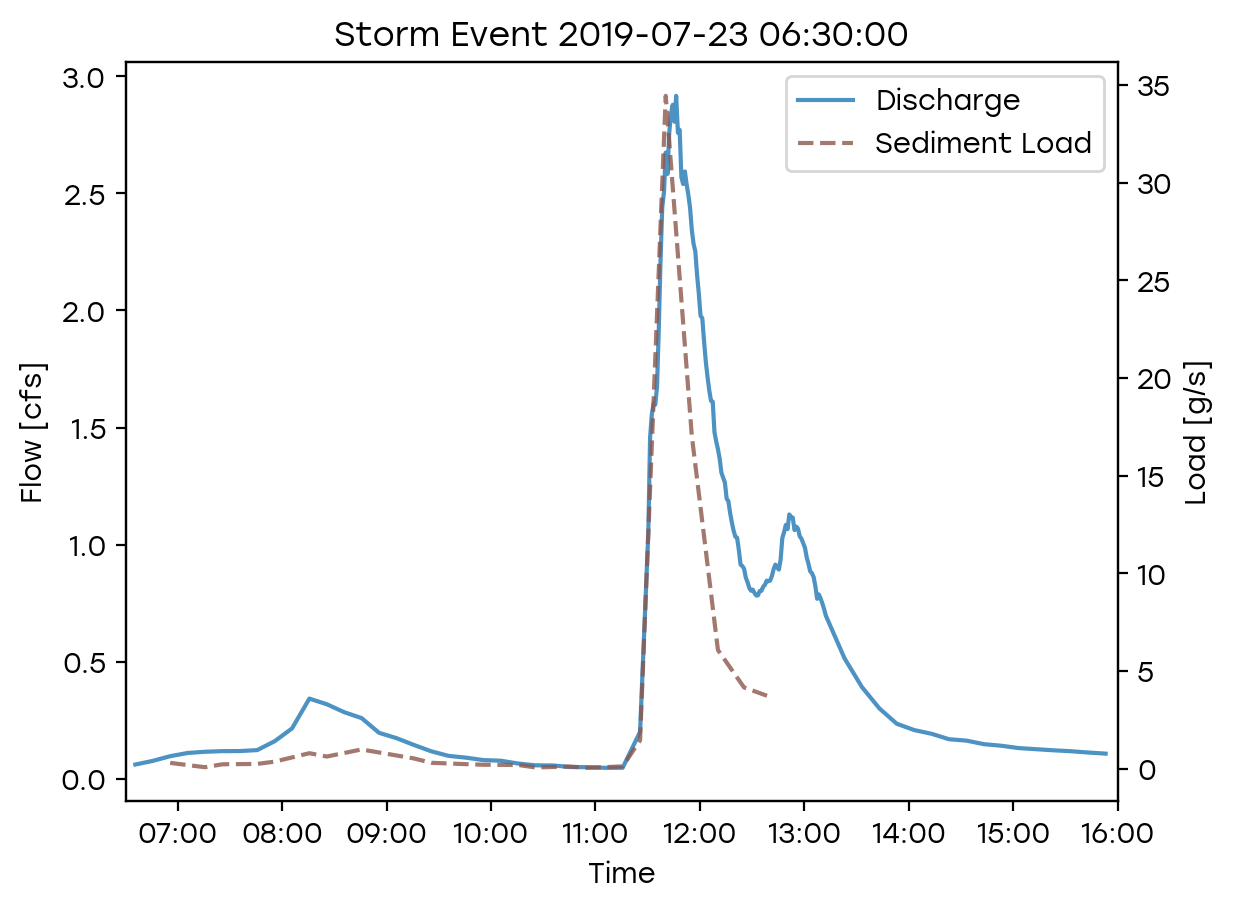

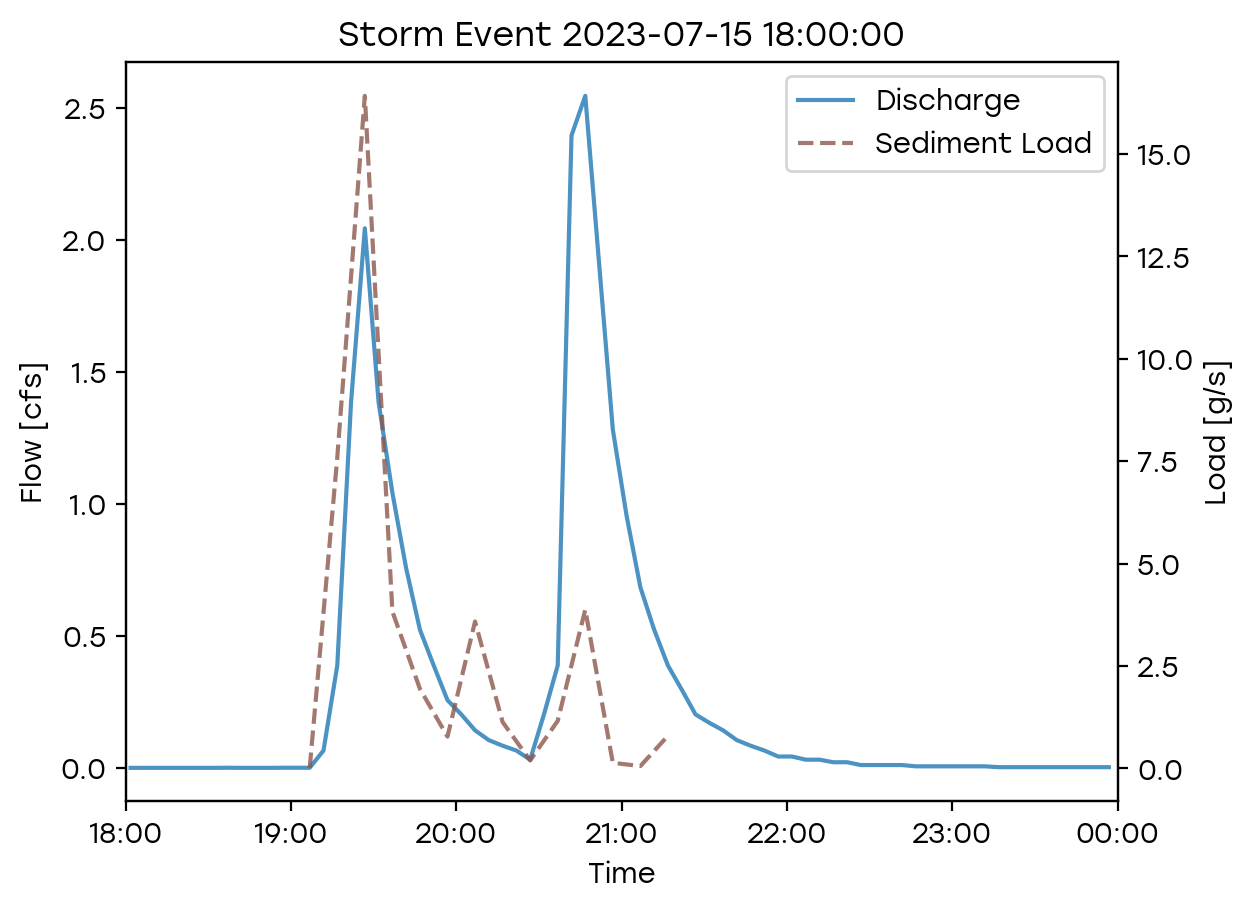

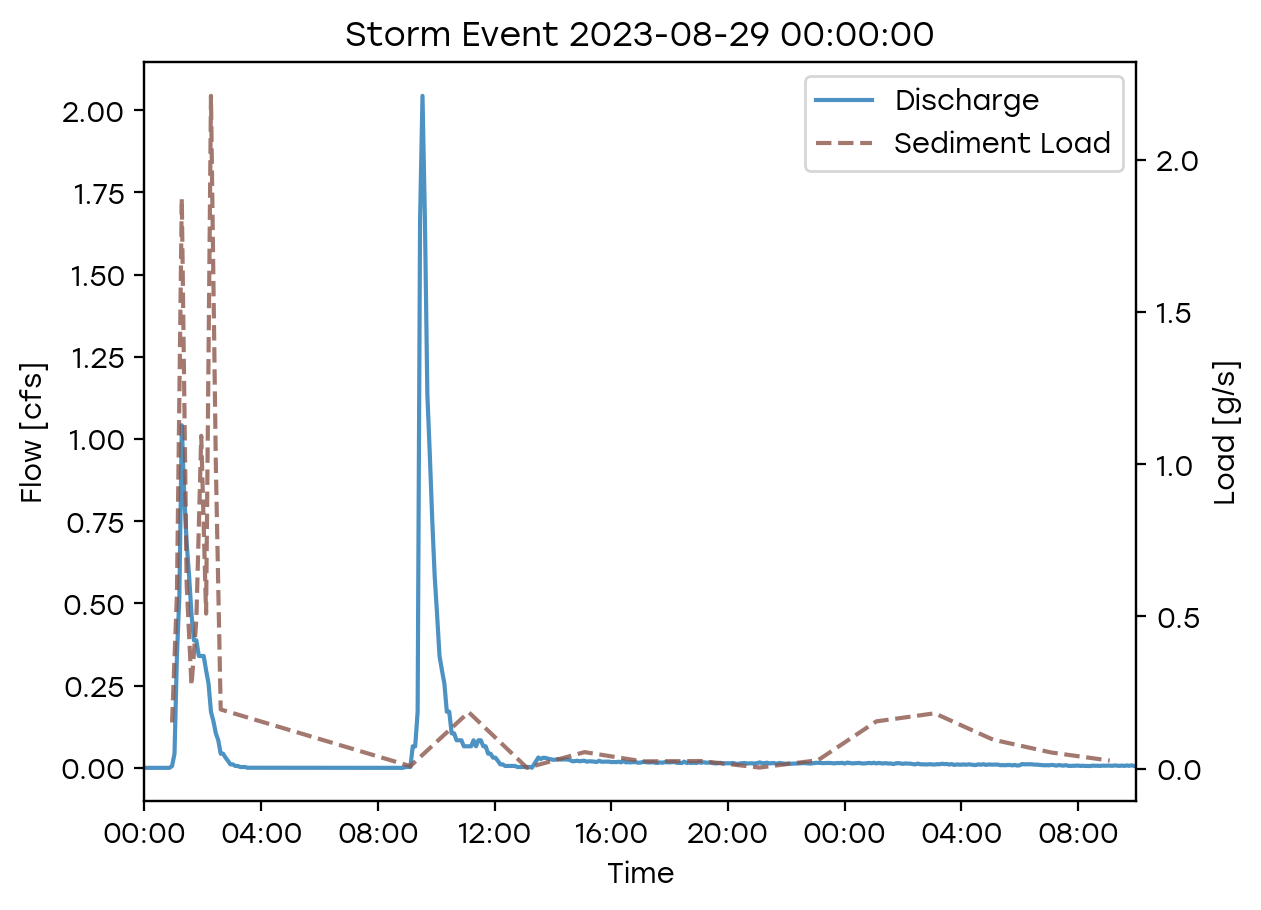

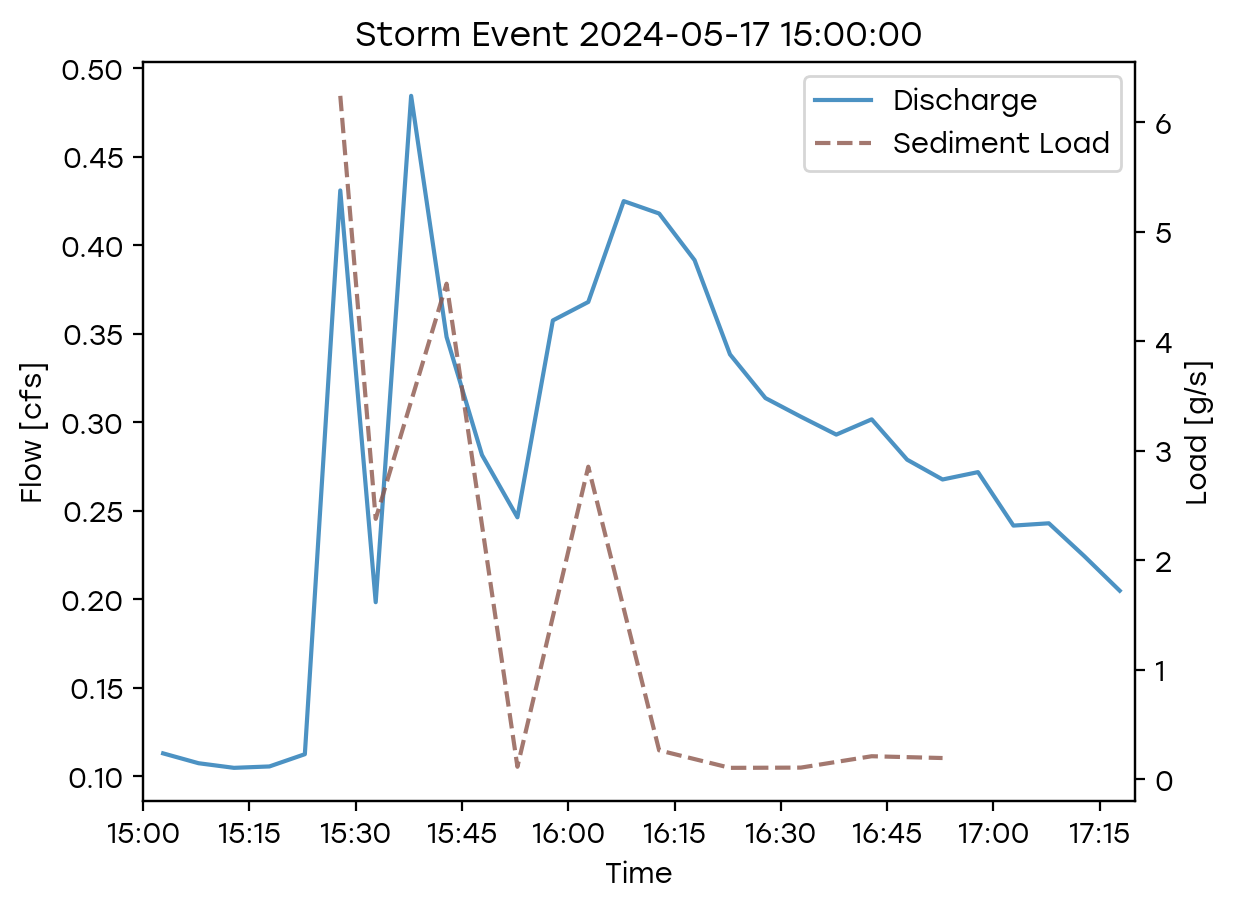

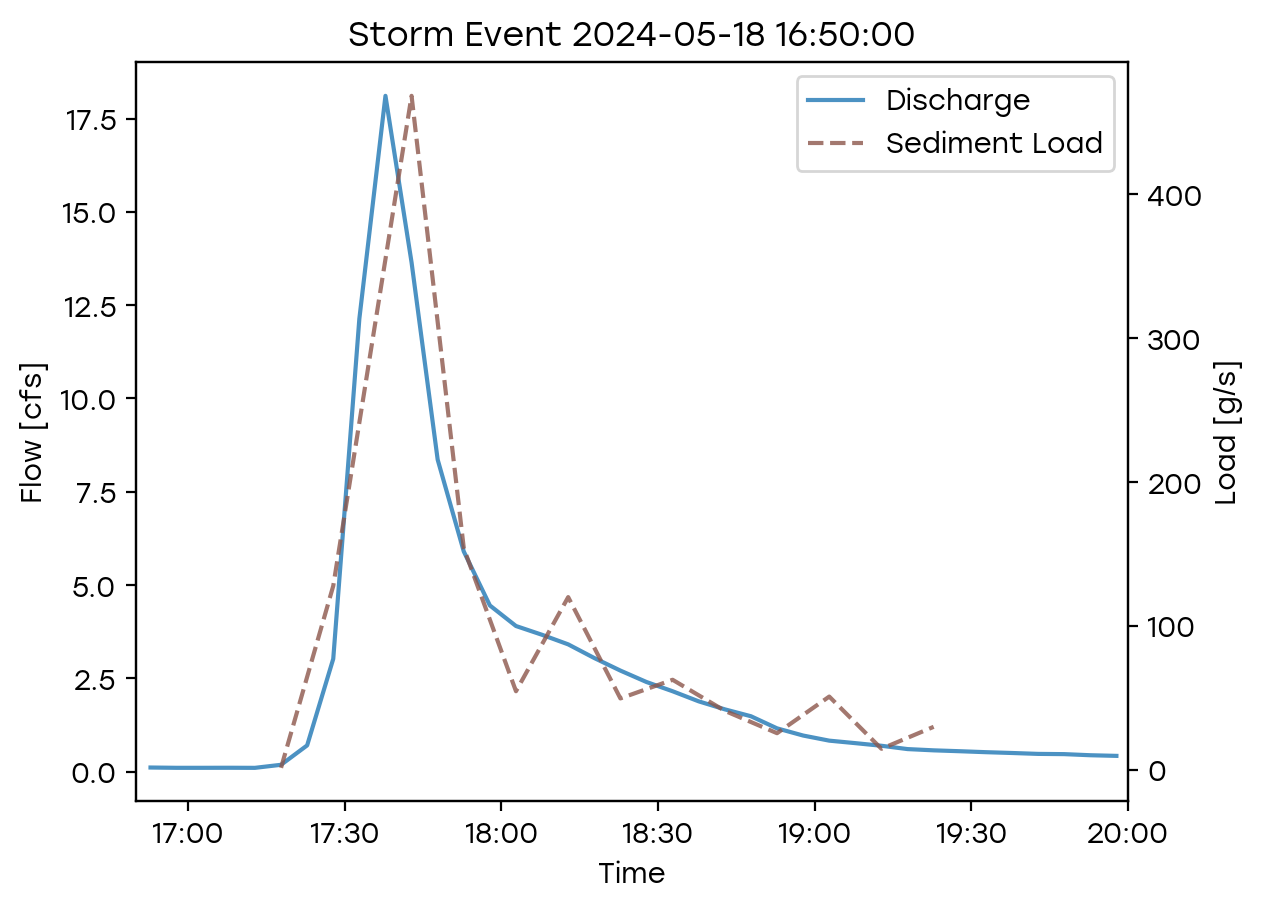

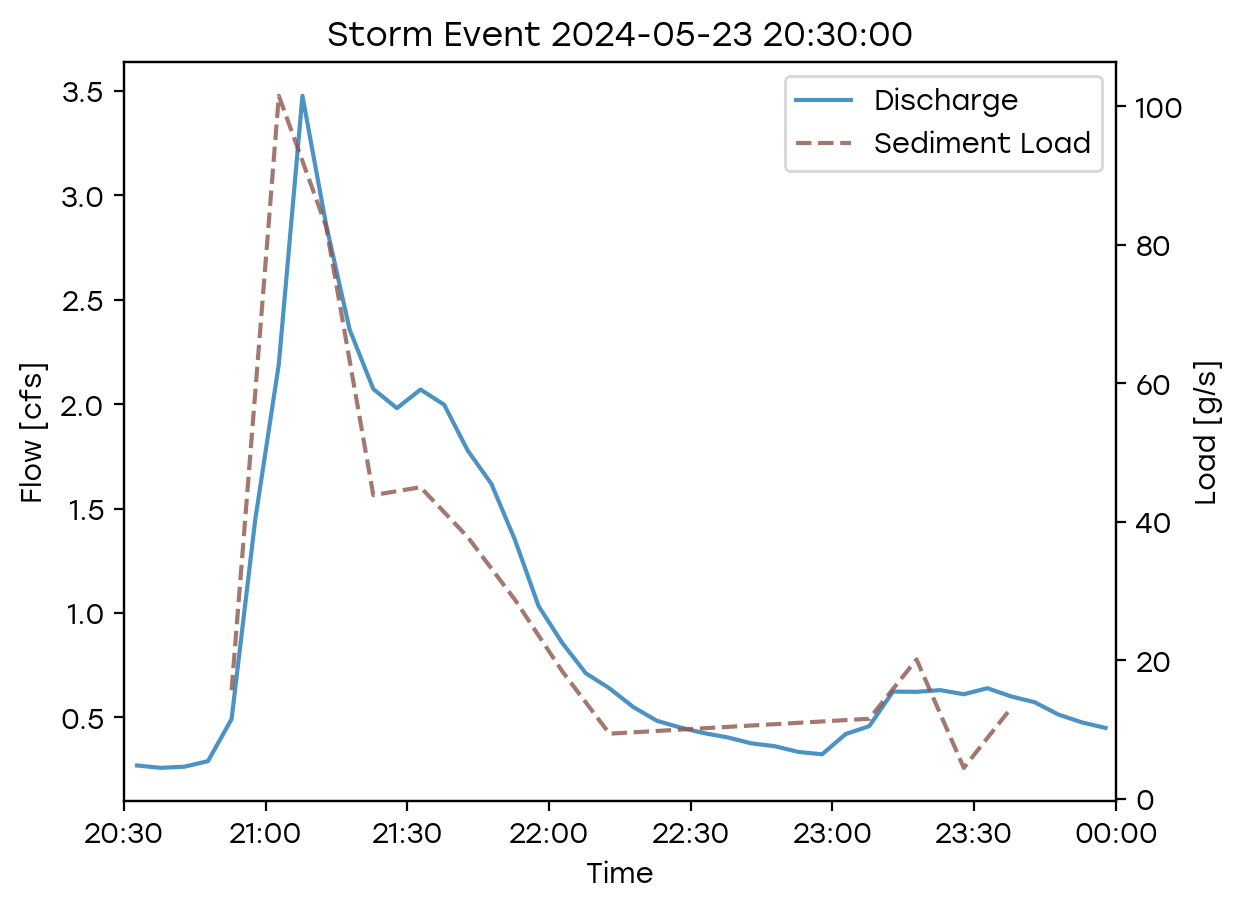

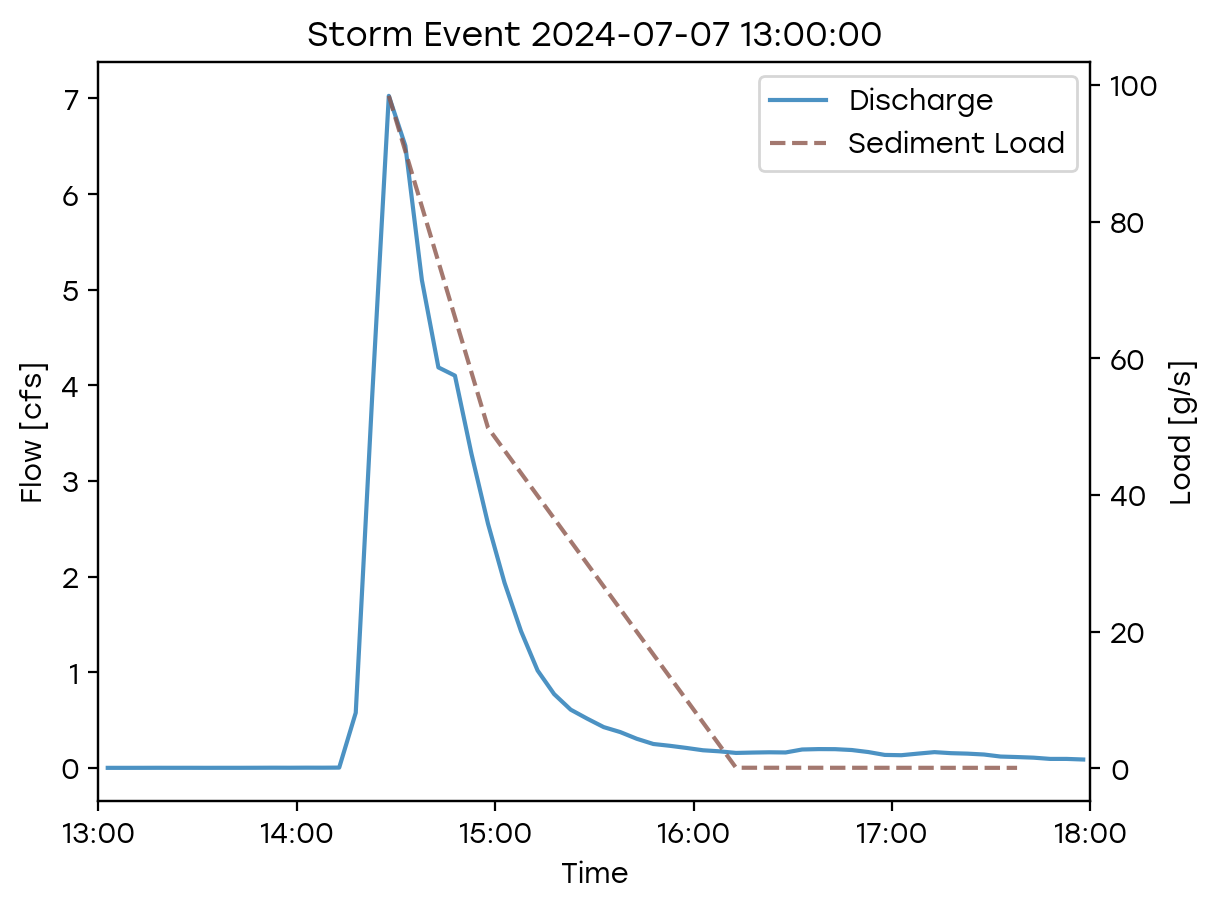

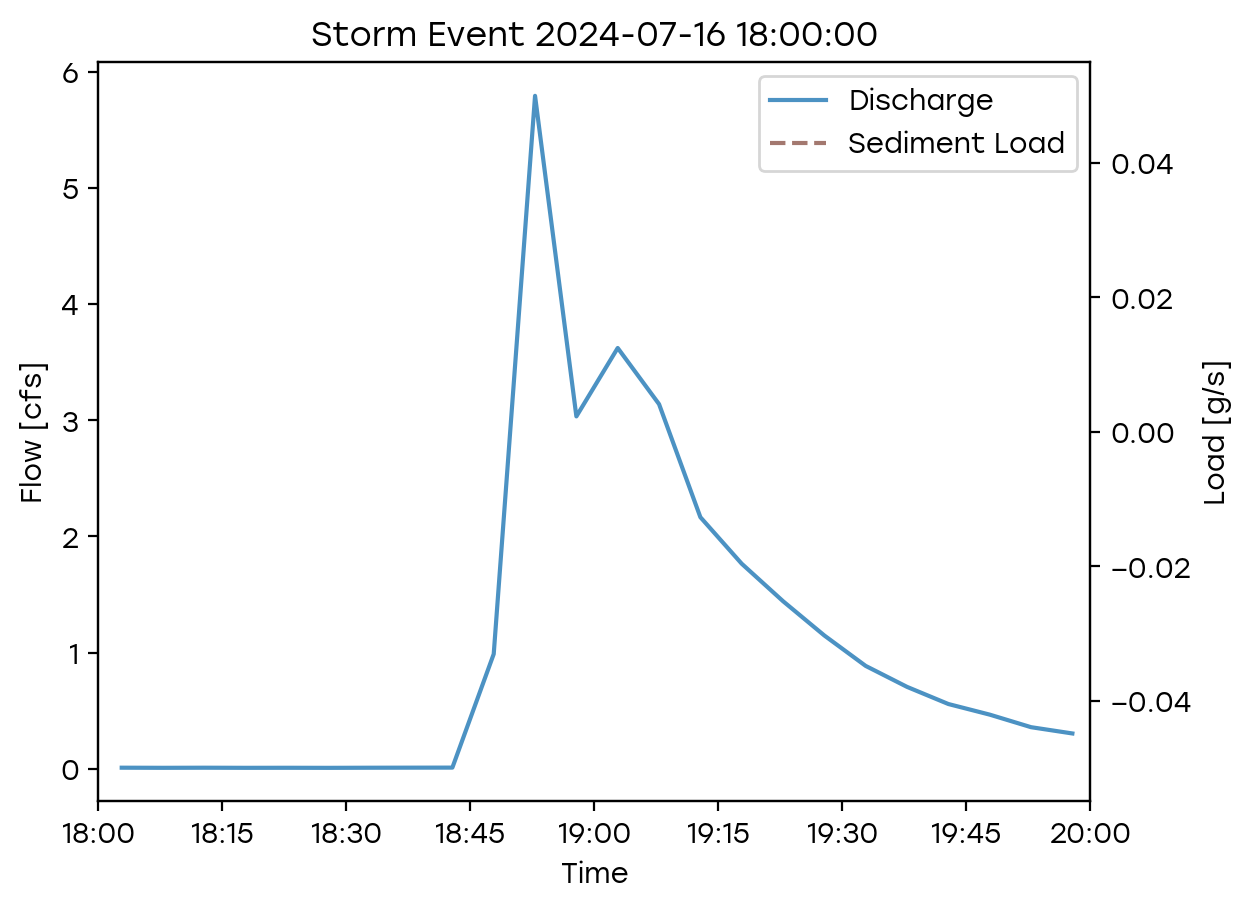

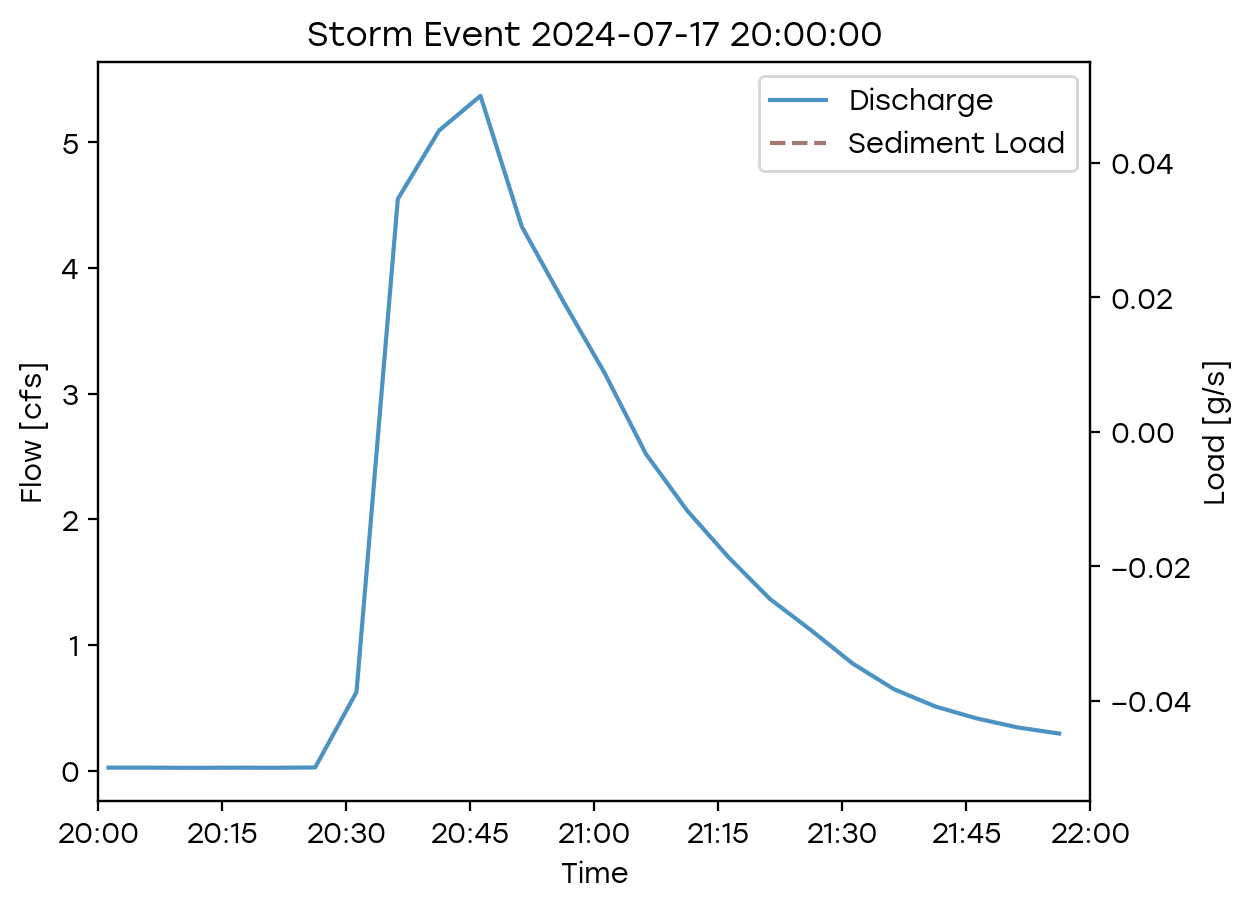

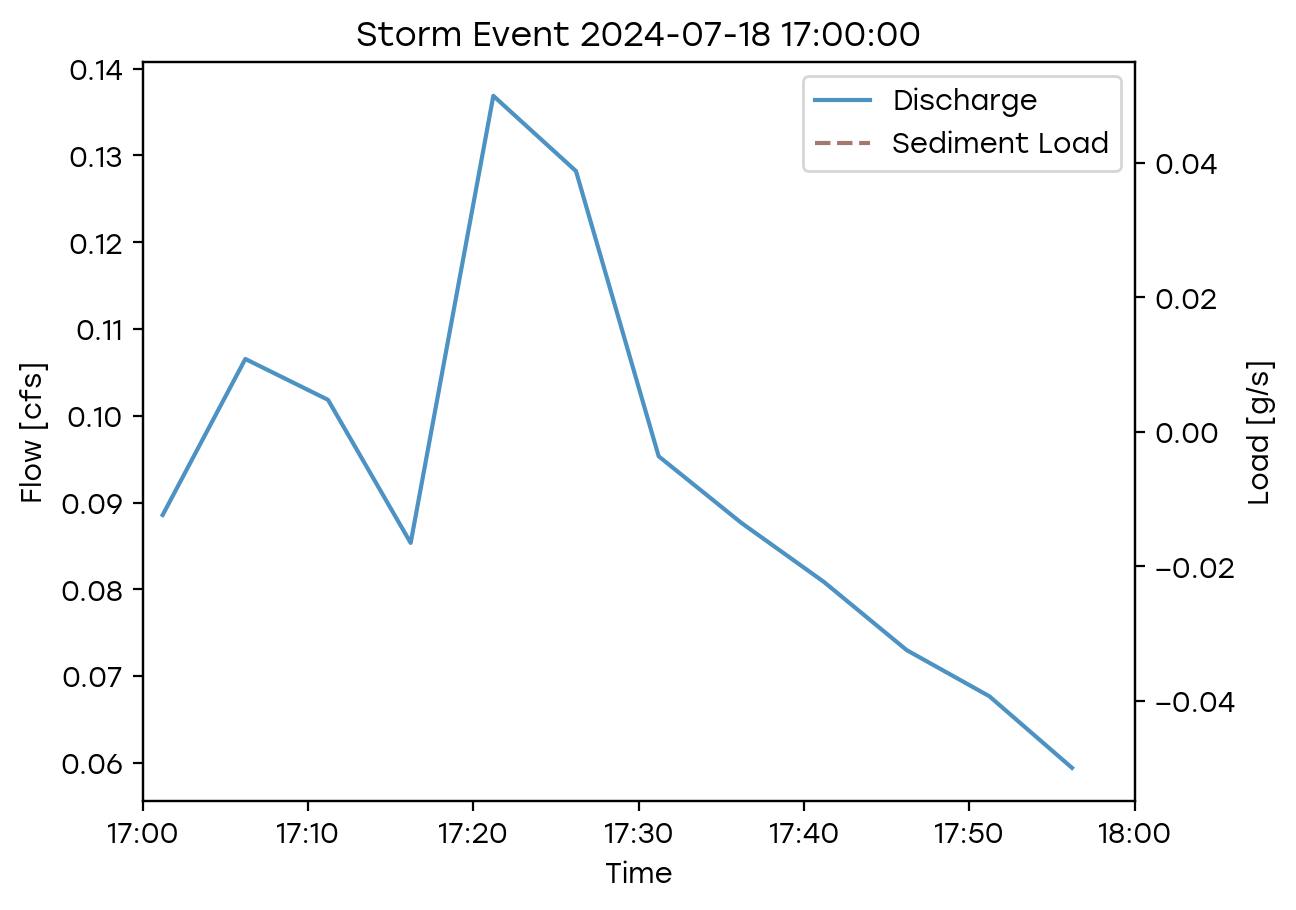

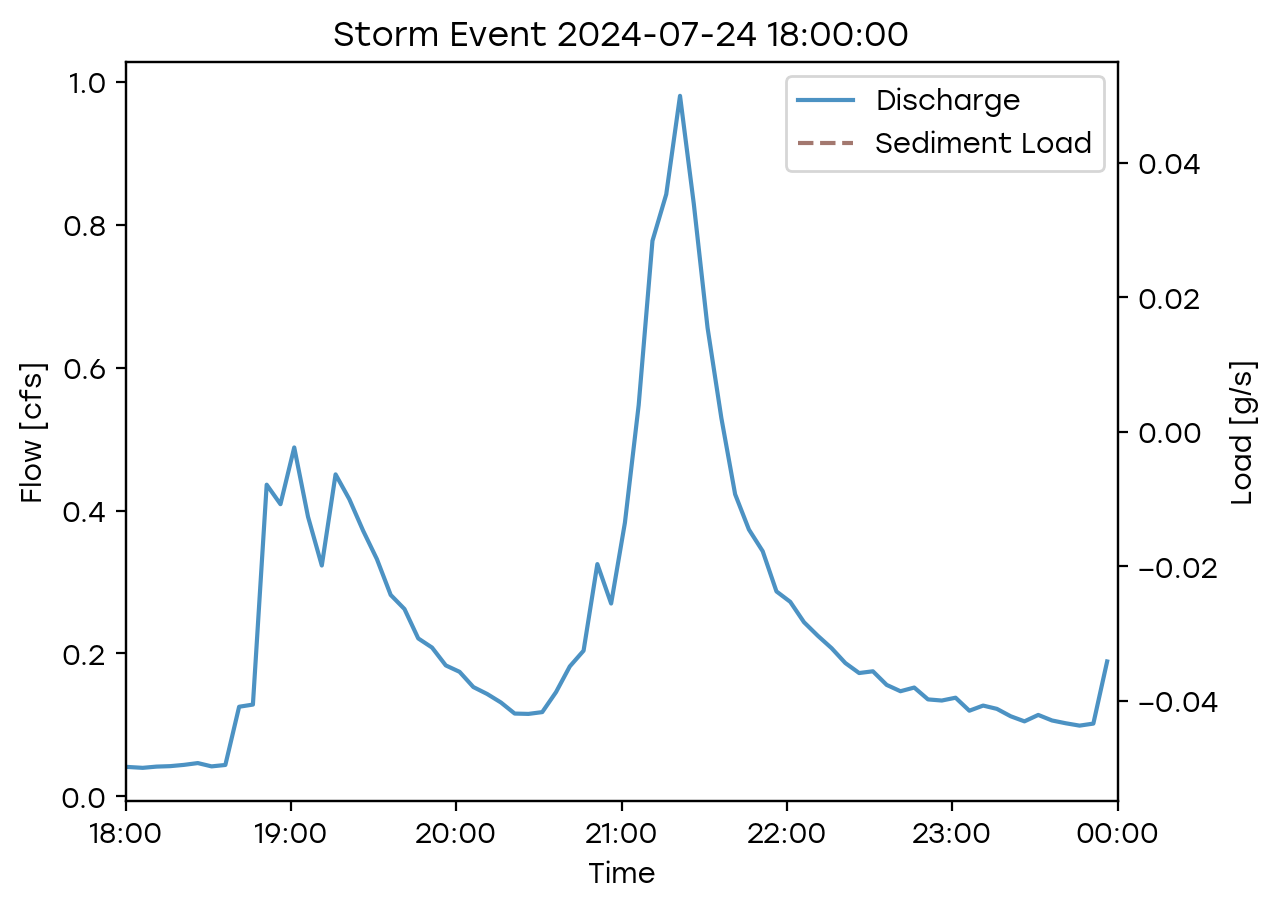

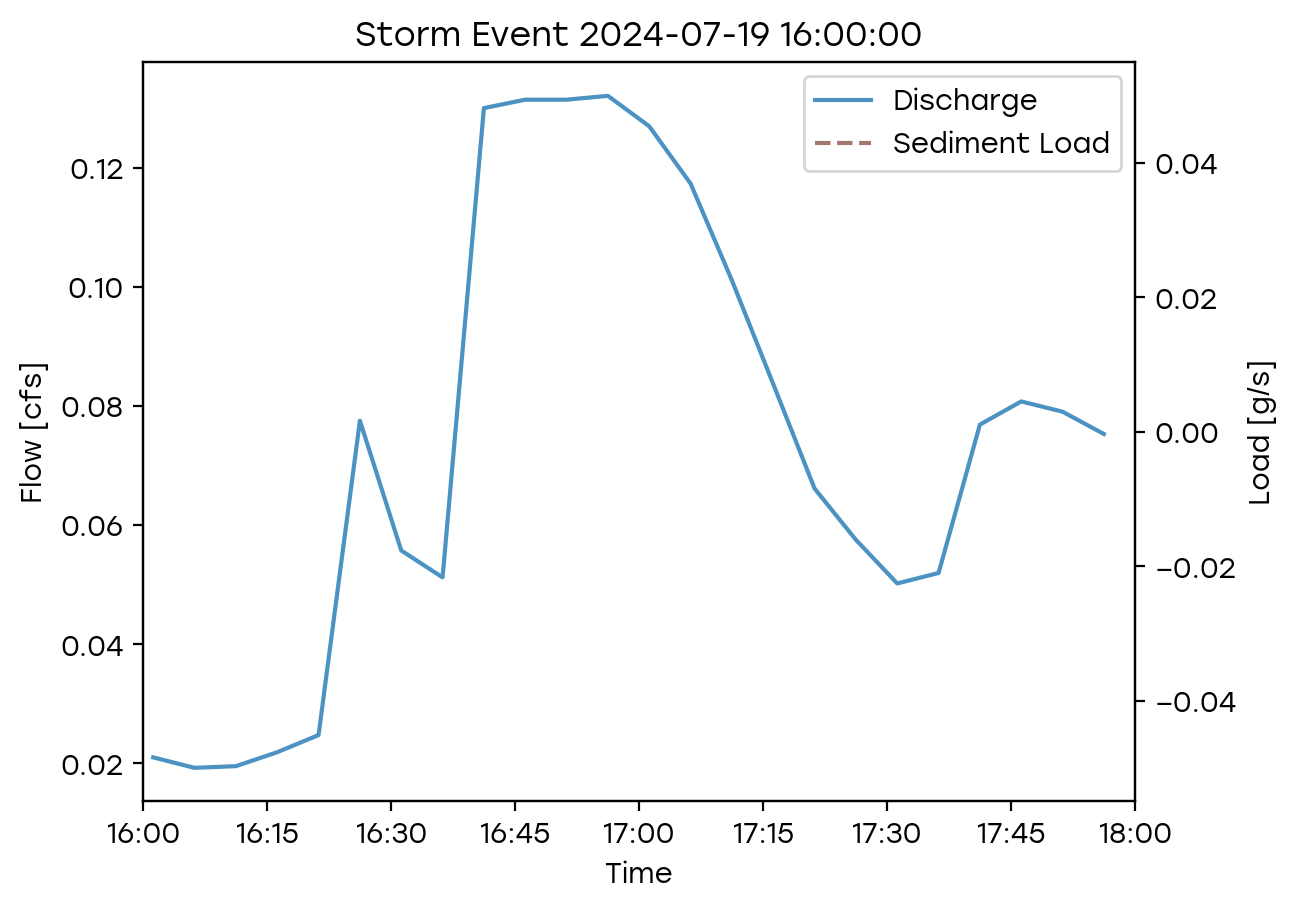

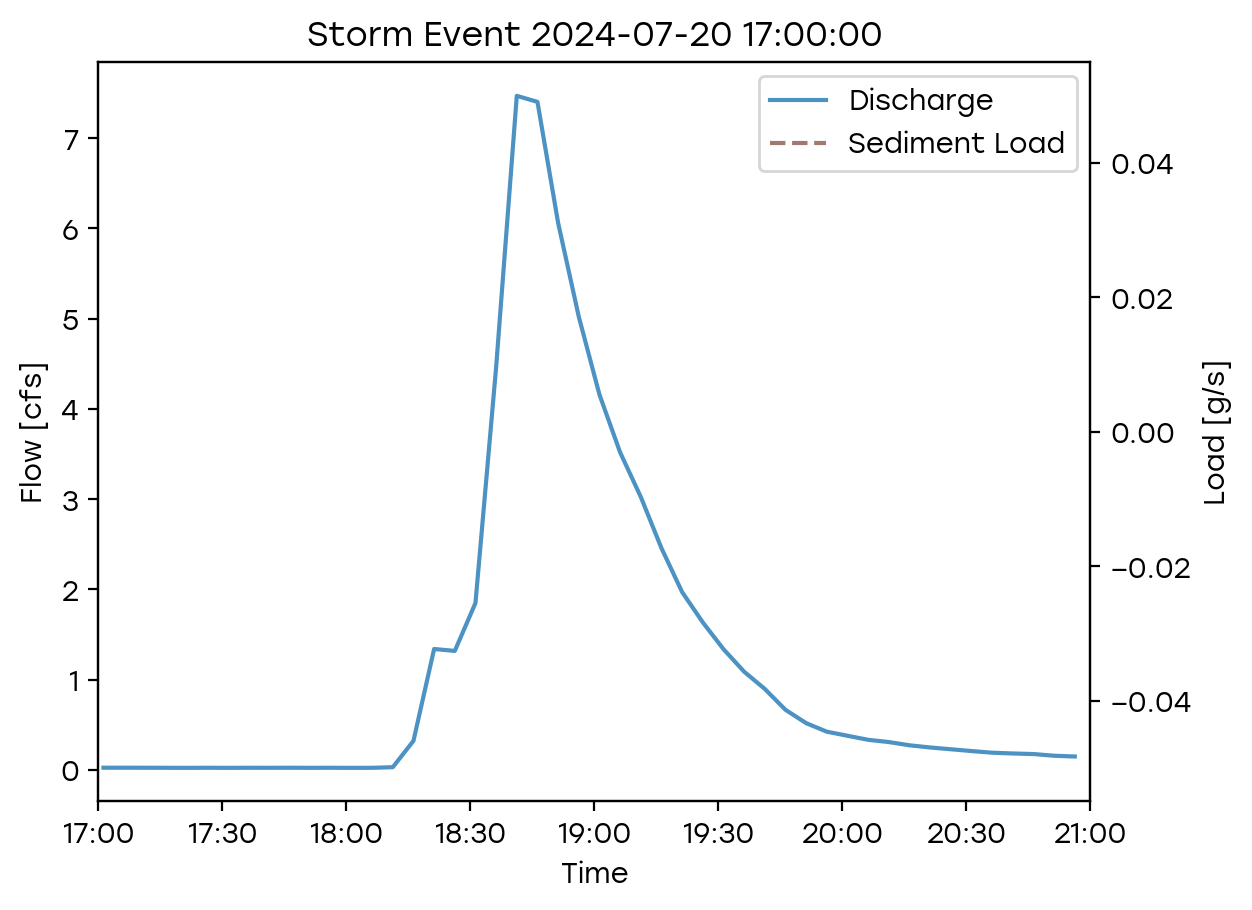

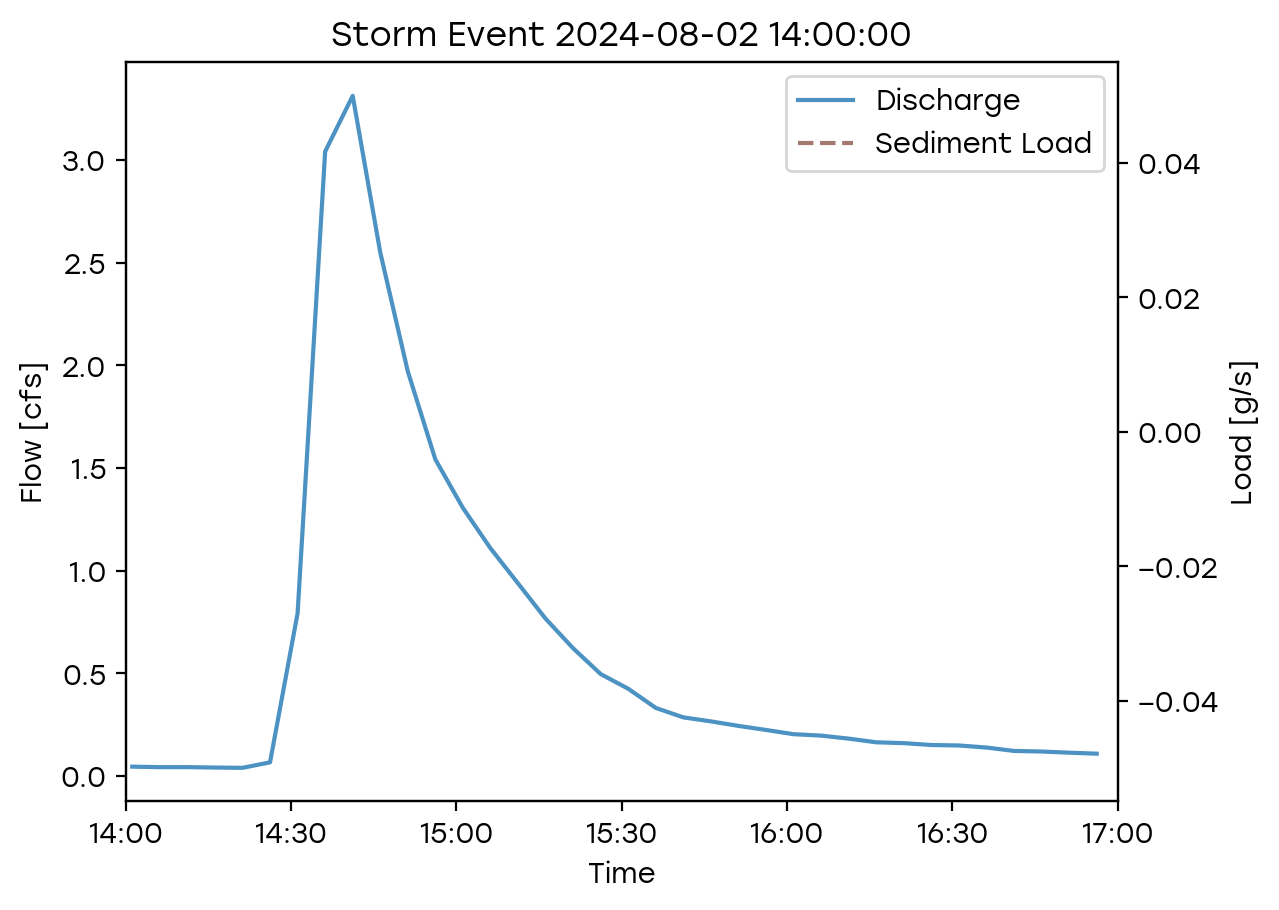

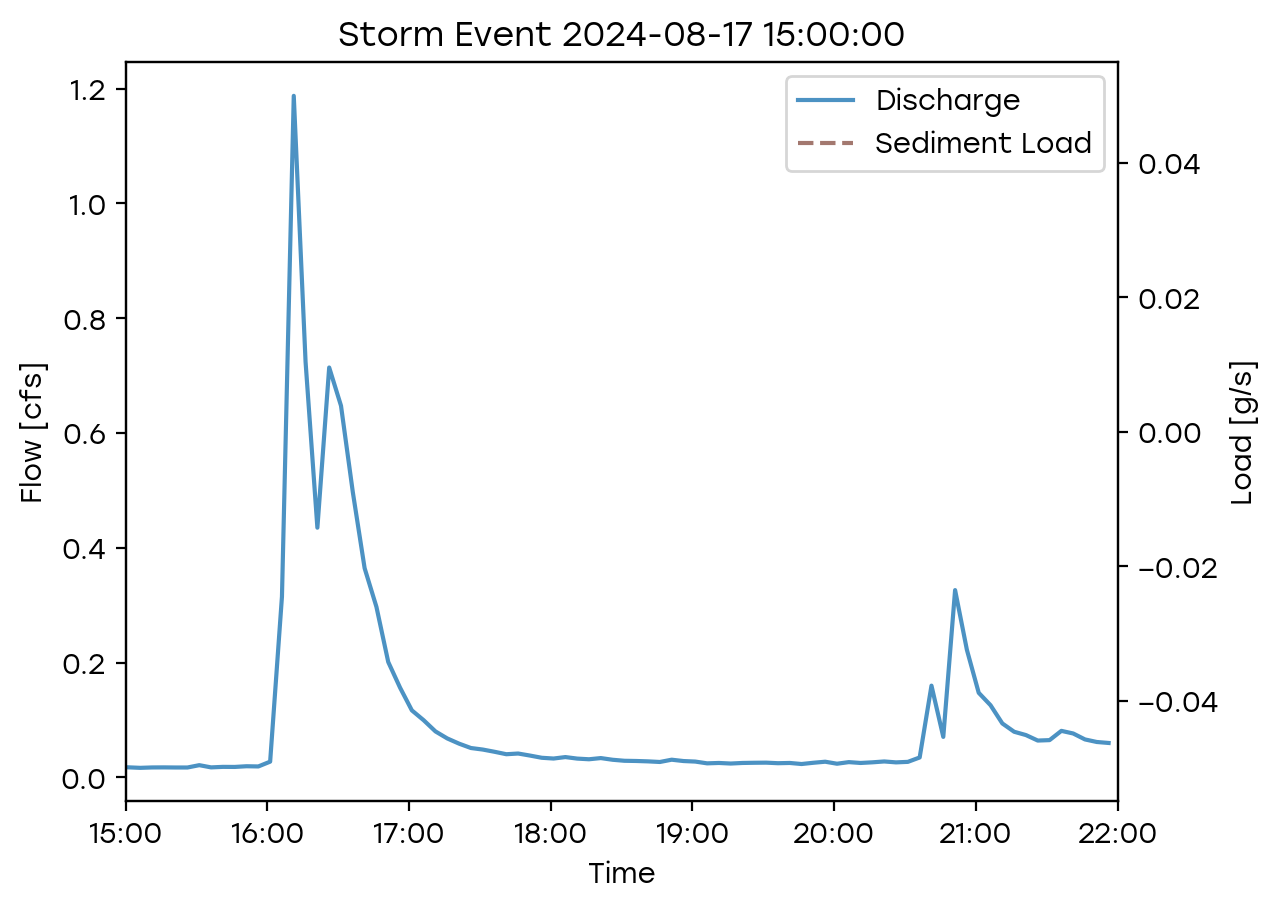

In [20]:
def plot_event(stage_sed_df, event_start, event_end):
    # filter master df to only be during event timespan
    event_df = stage_sed_df[(stage_sed_df['date_time_stage'] >= event_start) & (stage_sed_df['date_time_stage'] <= event_end)]
    # make sediment data continuous by dropping stage timestamps it didn't record for
    event_df_sed = event_df.dropna(subset=['conc_mg_L'])
    # display(event_df)
    # Q_trans = Q_Sam_frankenstein((P_rect-P_vnotch),P_rect,P_vnotch,B,angle_vnotch,units_str,b)


    # plot discharge vs. sed load time series
    fig1, ax1 = plt.subplots()

    # plot discharge vs. sed load with multiple weir equations
    # plot flow on first y-axis
    # line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    # line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    # line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    line1, = ax1.plot(event_df['date_time_stage'], event_df['Q_cfs_HollyFrank'], ls='-', color='tab:blue', alpha=0.8, label='Discharge')
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # plot sediment load on second y-axis
    ax2 = ax1.twinx()
    # line4, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_SamFrank'], ls='--', color='tab:blue', alpha=0.7, label='Qs Sam') # marker='s'
    # line5, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:orange', alpha=0.7, label='Qs Holly') # marker='s'
    # line6, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_PhilFrank'], ls='--', color='tab:grey', alpha=0.5, label='Qs Phil') # marker='s' # plot old method
    line2, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:brown', alpha=0.8, label='Sediment Load')
    ax2.set_ylabel('Load [g/s]') #, color='tab:orange')
    ax2.tick_params(axis='y') # , labelcolor='tab:orange')
    # Formatting the x-axis to show only the time
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    # lines = [line1, line2, line3, line4, line5, line6]
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {}'.format(event_start))
    plt.show()
    # plt.close()
    
    return fig1


for i_event in range(len(events_nested_pairs)):
    event = events_nested_pairs[i_event]
    event_start = pd.Timestamp(str(event[0]))
    event_end = pd.Timestamp(str(event[1]))

    plot_event(stage_sed_df, event_start, event_end)
    # fig = plot_event(stage_sed_df, event_start, event_end)
    # plt.show()
    # plt.close()

Pre-Construction:
slope =  1.6565770734905374
intercept =  0.7414428709497874
R^2 =  0.7683015342248299
Pre-Construction:
slope =  1.5770735441016017
intercept =  0.6327734831970302
R^2 =  0.9341065792429367
Pre-Construction:
slope =  1.5937352027851106
intercept =  0.8932845703029274
R^2 =  0.5701066113624206


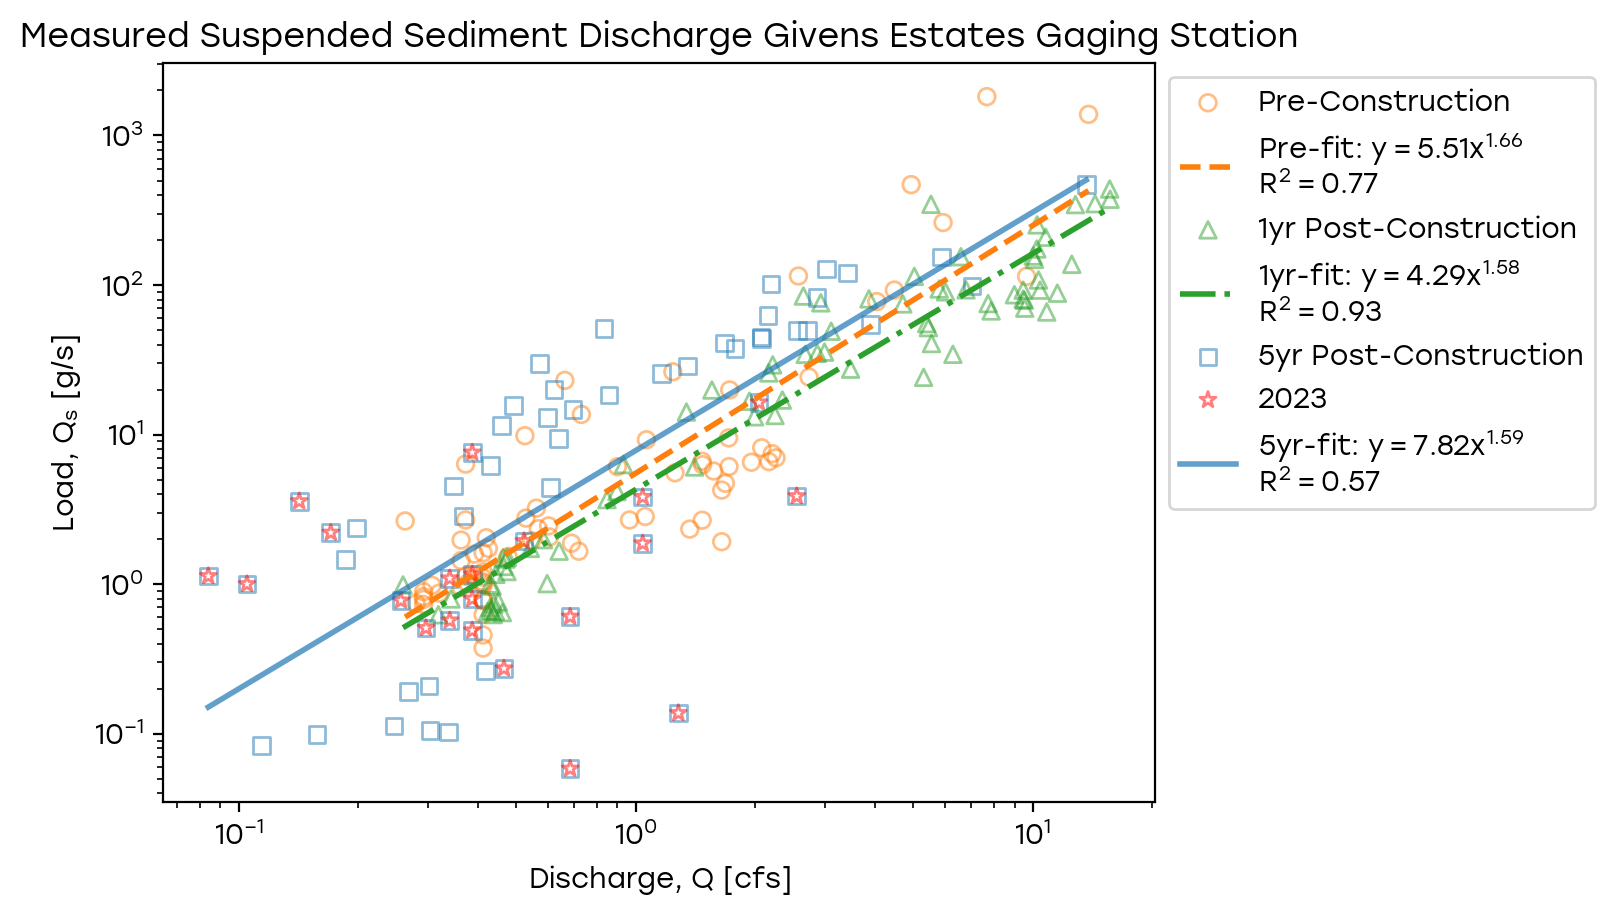

In [23]:
# create sediment rating curves (e.g., log-log plot of Load [g/s] vs. Q [cfs] with line of best fit and R^2])
# create dataframe for plot - only where ISCO was sampled
rating_curve_df = stage_sed_df.copy()
rating_curve_df = rating_curve_df.dropna(subset=['conc_mg_L'])
rating_curve_df = rating_curve_df[rating_curve_df['stage_corrected_ft'] > 0.2] # take out measurements below recommended minimum depth for v-notch weir

# tests
# rating_curve_df = rating_curve_df[rating_curve_df['Q_cfs_HollyFrank'] > 0.15]
# rating_curve_df = rating_curve_df[(rating_curve_df['date_time_stage'] < np.datetime64('2024-05-18')) | (rating_curve_df['date_time_stage'] >= np.datetime64('2024-05-19'))]
# rating_curve_df = rating_curve_df[(rating_curve_df['date_time_stage'] < np.datetime64('2024-05-23')) | (rating_curve_df['date_time_stage'] >= np.datetime64('2024-05-24'))]

# filter out data excluded in 2019 study
excluded_postExcel = [
    '2019-07-23 11:15',
    '2019-07-23 10:55',
    '2019-07-23 10:45',
    '2019-07-23 10:25',
    '2019-07-23 10:15',
    '2019-07-23 09:55',
    '2019-07-23 09:45',
    '2019-07-23 06:55',
    '2019-07-23 07:15',
    '2019-07-23 09:25',
    '2019-07-23 07:25',
    '2019-07-23 07:45',
    '2019-07-23 09:15',
    '2019-07-23 07:55',
    '2019-07-23 08:55',
    '2019-07-23 11:25',
]
rating_curve_df['timestamp_no_seconds'] = rating_curve_df['date_time_isco'].dt.strftime('%Y-%m-%d %H:%M')
rating_curve_df = rating_curve_df[~rating_curve_df['timestamp_no_seconds'].isin(excluded_postExcel)]
rating_curve_df = rating_curve_df.drop(columns=['timestamp_no_seconds'])

# split dataframes in to pre vs. post timeframes
pre_rating_df = rating_curve_df[rating_curve_df['date_time_stage'] < np.datetime64('2019-01-01')]
post_1yr_rating_df = rating_curve_df[(rating_curve_df['date_time_stage'] >= np.datetime64('2019-01-01')) & (rating_curve_df['date_time_stage'] < np.datetime64('2020-01-01'))]
post_5yr_rating_df = rating_curve_df[rating_curve_df['date_time_stage'] > np.datetime64('2023-01-01')]

Q_pre = pre_rating_df['Q_cfs_HollyFrank']
load_pre = pre_rating_df['load_g_s_HollyFrank']
Q_1yr = post_1yr_rating_df['Q_cfs_HollyFrank']
load_1yr = post_1yr_rating_df['load_g_s_HollyFrank']
Q_5yr = post_5yr_rating_df['Q_cfs_HollyFrank']
load_5yr = post_5yr_rating_df['load_g_s_HollyFrank']

# Q_pre = pre_rating_df['Q_cfs_SamFrank']
# load_pre = pre_rating_df['load_g_s_SamFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_SamFrank']
# load_1yr = post_1yr_rating_df['load_g_s_SamFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_SamFrank']
# load_5yr = post_5yr_rating_df['load_g_s_SamFrank']

# Q_pre = pre_rating_df['Q_cfs_PhilFrank']
# load_pre = pre_rating_df['load_g_s_PhilFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_PhilFrank']
# load_1yr = post_1yr_rating_df['load_g_s_PhilFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_PhilFrank']
# load_5yr = post_5yr_rating_df['load_g_s_PhilFrank']

# pre
x = np.array(Q_pre).reshape(-1,1)
y = np.array(load_pre)
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='Pre-Construction', alpha=0.5, marker='o', facecolors='none', edgecolors='tab:orange')
plt.plot(x_plot, y_plot, ls='--', lw='2', color='tab:orange', label='Pre-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

# post 1yr
x = np.array(Q_1yr).reshape(-1,1)
y = np.array(load_1yr)
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='1yr Post-Construction', alpha=0.5, marker='^', facecolors='none', edgecolors='tab:green')
plt.plot(x_plot, y_plot, ls='-.', lw='2', color='tab:green', label='1yr-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

# post 5yr
x = np.array(Q_5yr).reshape(-1,1)
y = np.array(load_5yr)
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='5yr Post-Construction', alpha=0.5, marker='s', facecolors='none', edgecolors='tab:blue')
# quick check
post_4yr_rating_df = rating_curve_df[(rating_curve_df['date_time_stage'] > np.datetime64('2023-01-01')) & (rating_curve_df['date_time_stage'] < np.datetime64('2024-01-01'))]
Q_4yr = post_4yr_rating_df['Q_cfs_HollyFrank']
load_4yr = post_4yr_rating_df['load_g_s_HollyFrank']
x_test = np.array(Q_4yr).reshape(-1,1)
y_test = np.array(load_4yr)
plt.scatter(x_test, y_test, label='2023', alpha=0.5, marker='*', facecolors='none', edgecolors='red')
plt.plot(x_plot, y_plot, alpha=0.7, ls='-', lw='2', color='tab:blue', label='5yr-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Discharge, $Q$ [cfs]')
plt.ylabel('Load, $Q_s$ [g/s]')
plt.title('Measured Suspended Sediment Discharge Givens Estates Gaging Station')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
# plt.show()
# plt.close()


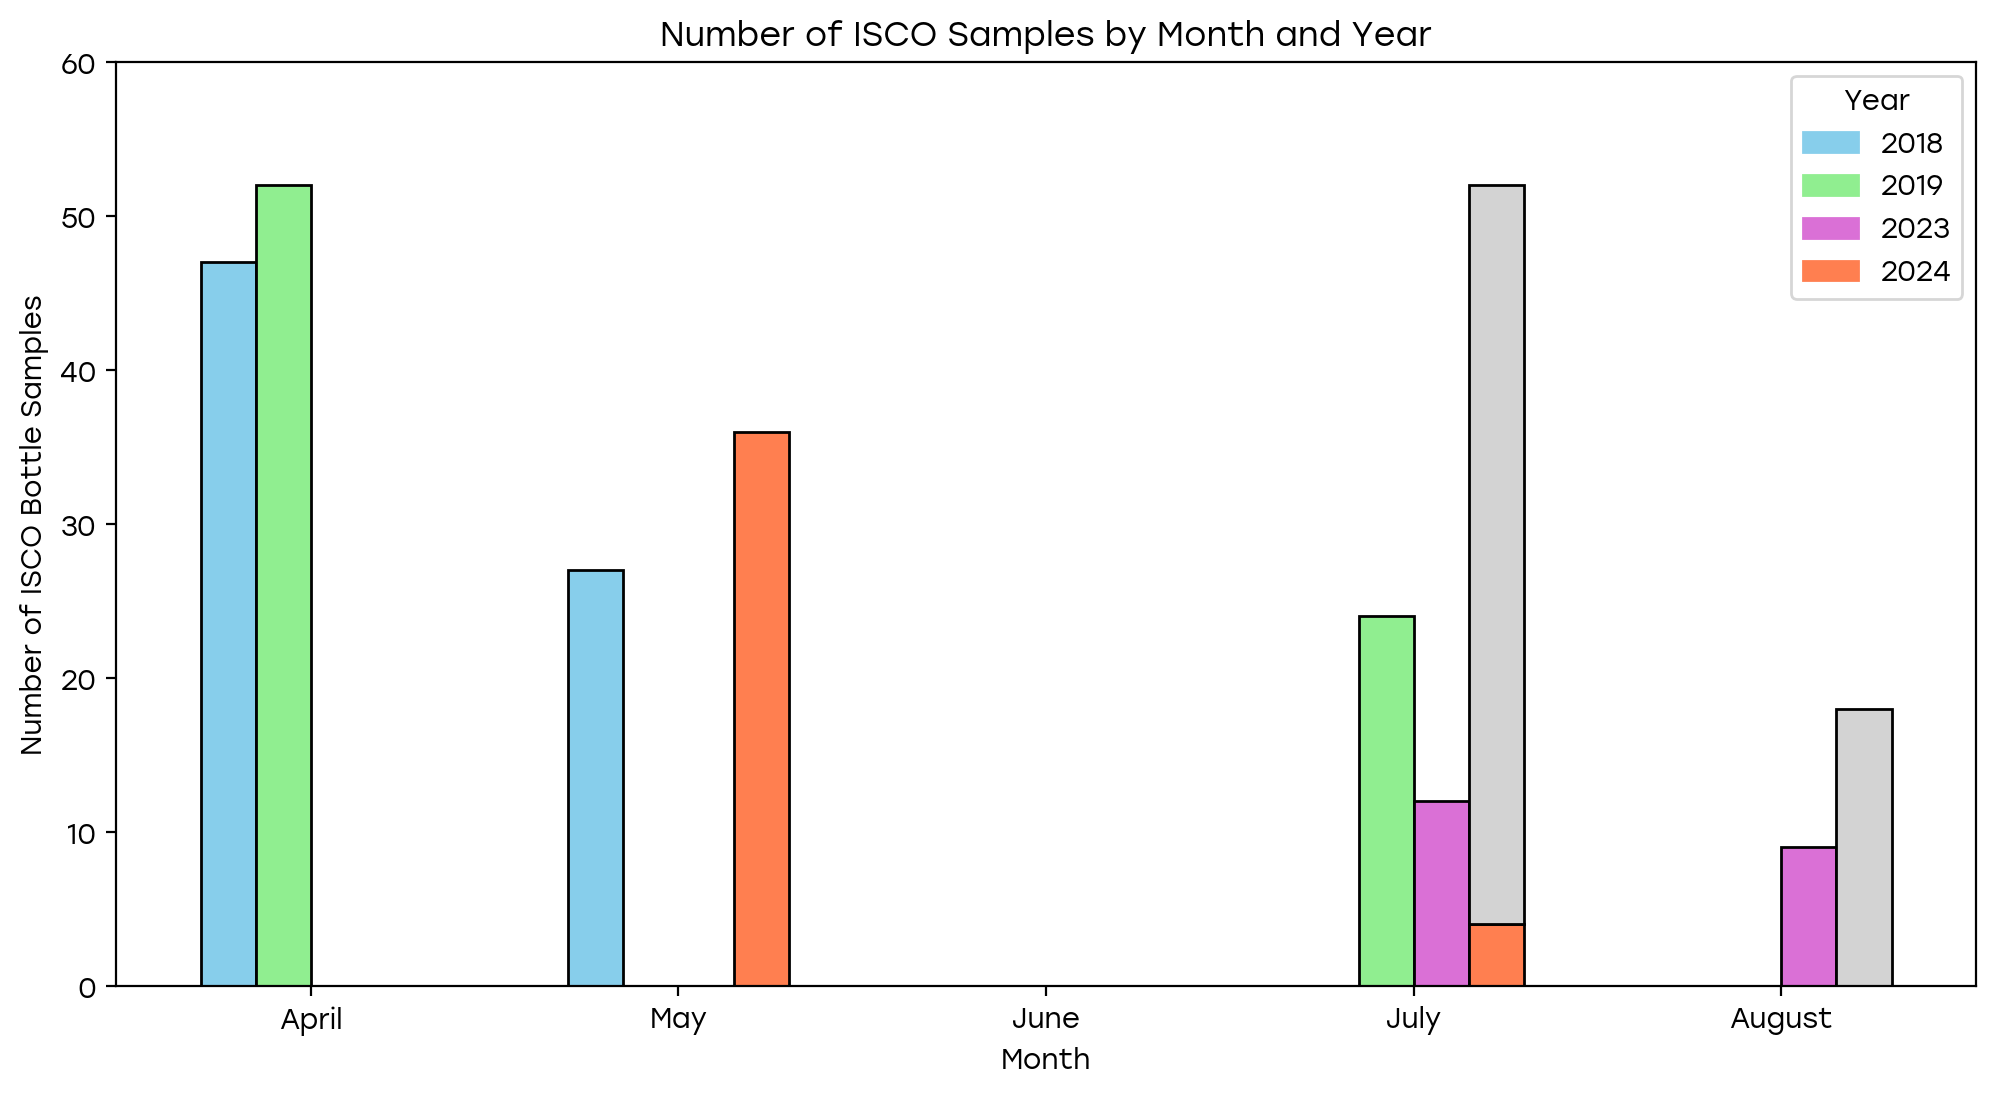

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming rating_curve_df is already defined and loaded with data

# Extract year and month
rating_curve_df['year'] = rating_curve_df['date_time_stage'].dt.year
rating_curve_df['month'] = rating_curve_df['date_time_stage'].dt.month

# Get a list of unique years
years = sorted(rating_curve_df['year'].unique())

# Define the months April (4) to August (8)
months_to_display = [4, 5, 6, 7, 8]
month_names = {4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}

# Custom bar segments
custom_bars = {
    (2024, 7): (4, 48),  # July 2024: 4 units blue, 48 units gray
    (2024, 8): (0, 18),  # August 2024: 0 units blue, 18 units gray
}

# Define arbitrary numbers to display above the bars
arbitrary_numbers = {
    (2018, 4): 4,  
    (2018, 5): 3,
    (2019, 4): 1,
    (2019, 7): 3,
    (2023, 7): 1,
    (2023, 8): 3,
    (2024, 5): 3,
    (2024, 7): 7,
    (2024, 8): 2,
}

# Define colors for each year
color_yrs_li = ['skyblue', 'lightgreen', 'orchid', 'coral']

# Aggregate the data by year and month
df_grouped = rating_curve_df.groupby(['year', 'month']).size().unstack(fill_value=0).reindex(columns=months_to_display, fill_value=0)

# Define bar width
bar_width = 0.15
month_indices = np.arange(len(months_to_display))

# Create a grouped bar plot
plt.figure(figsize=(12, 6))

# Create an empty list for legend patches
legend_patches = []

# Plot bars for each year
for i, year in enumerate(years):
    for j, month in enumerate(months_to_display):
        count = df_grouped.at[year, month]
        if (year, month) in custom_bars:
            blue_part, gray_part = custom_bars[(year, month)]
            bar1 = plt.bar(month_indices[j] + i * bar_width, blue_part, width=bar_width, color=color_yrs_li[i], edgecolor='black')
            bar2 = plt.bar(month_indices[j] + i * bar_width, gray_part, bottom=blue_part, width=bar_width, color='lightgray', edgecolor='black')
        else:
            bar = plt.bar(month_indices[j] + i * bar_width, count, width=bar_width, color=color_yrs_li[i], edgecolor='black')
    
    # Add a patch for the legend
    patch = patches.Patch(color=color_yrs_li[i], label=str(year))
    legend_patches.append(patch)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Number of ISCO Bottle Samples')
plt.title('Number of ISCO Samples by Month and Year')
plt.xticks(month_indices + bar_width * (len(years) - 1) / 2, [month_names[m] for m in months_to_display], rotation=0)
plt.ylim([0, 60])

# Add legend with correct colors
plt.legend(handles=legend_patches, title='Year', loc='upper right', ncol=1, fontsize=10)

# Remove the gridlines
plt.grid(False)

# Show the plot
plt.show()


In [14]:
# display(pre_rating_df)
# display(post_1yr_rating_df)
pd.set_option('display.max_rows', None)
display(post_5yr_rating_df.sort_values(by='load_g_s_HollyFrank'))
pd.reset_option('display.max_rows')

,date_time_stage,stage_raw,stage_corrected_ft,date_time_isco,conc_mg_L,Q_cfs_PhilFrank,Q_cfs_Bergmann,Q_cfs_SamFrank,Q_cfs_HollyFrank,load_g_s_PhilFrank,load_g_s_SamFrank,load_g_s_HollyFrank
79718,2023-07-15 21:06:50,0.4900,0.4900,2023-07-15 21:08:00.000,3.015075,0.421686,-6.998757,0.683858,0.683858,0.036003,0.058386,0.058386
172205,2024-07-07 17:37:49,0.2381,0.2381,2024-07-07 17:38:00.000,25.685786,0.070473,-10.323837,0.114325,0.114325,0.051258,0.083153,0.083153
172188,2024-07-07 16:12:49,0.2710,0.2710,2024-07-07 16:14:00.000,22.084367,0.097054,-9.889557,0.157397,0.157397,0.060694,0.098430,0.098430
128236,2024-05-17 16:22:49,0.3692,0.3692,2024-05-17 16:22:00.000,10.723192,0.208811,-8.593317,0.338346,0.338346,0.063405,0.102738,0.102738
128238,2024-05-17 16:32:49,0.3532,0.3532,2024-05-17 16:32:00.000,12.219451,0.187081,-8.804517,0.303158,0.303158,0.064733,0.104898,0.104898
128230,2024-05-17 15:52:49,0.3248,0.3248,2024-05-17 15:52:00.000,16.169154,0.151977,-9.179397,0.246327,0.246327,0.069584,0.112784,0.112784
79716,2023-07-15 20:56:50,0.6300,0.6300,2023-07-15 20:58:00.000,3.787879,0.787808,-5.150757,1.280925,1.280925,0.084501,0.137394,0.137394
128242,2024-05-17 16:52:49,0.3359,0.3359,2024-05-17 16:52:00.000,25.373134,0.165177,-9.032877,0.267697,0.267697,0.118678,0.192338,0.192338
128240,2024-05-17 16:42:49,0.3525,0.3525,2024-05-17 16:42:00.000,24.438903,0.186163,-8.813757,0.301672,0.301672,0.128831,0.208768,0.208768
128234,2024-05-17 16:12:49,0.4020,0.4020,2024-05-17 16:12:00.000,22.194514,0.257915,-8.160357,0.417909,0.417909,0.162095,0.262648,0.262648
